# Stability Demo

Optimal number of topics is supposed to make models more stable in some way.
For example, [renormalization](Renormalization-Demo.ipynb) is also about stability: entropy means uncertainty, so the lower the entropy, the more stable the model is and so the better is the corresponding number of topics.

Here goes a more intuitive way to estimate stability: train models on different data subsamples and compare them.
Optimal number of topics is supposed to let models trained on different documents of the same collection be alike.
There are a couple of technical questions though, such as:
* how big should training subsamples be
* how to estimate the distance between topic models/between topics of topic models

Another way to introduce some noise in the training process would be to change the order of documents in the collection.
However, the order of documents doesn't play any role in [BigARTM library](https://github.com/bigartm/bigartm) — at least when using `artm.ARTM.fit_offline()`.

# Contents<a id="contents"></a>

* [Data](#data)
* [Experiment](#experiment)
* [Plots](#plots)
    * [PostNauka](#postnauka)
    * [Brown](#brown)
    * [Twenty Newsgroups](#twenty-newsgroups)
    * [Reuters](#reuters)
    * [WikiRef220](#wikiref)
    * [Good RU Wiki](#good-ru-wiki)
* [Appendix. Some Developer Notes](#dev-notes)

In [ ]:
# General imports

import copy
import json
import os
import tempfile

from matplotlib import pyplot as plt
from typing import (
    Dict,
    List,
)

%matplotlib inline

In [ ]:
plt.rcParams['font.size']

10.0

In [ ]:
plt.rcParams.update({'font.size': 20})

In [ ]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [ ]:
# Optimal number of topics

from topicnet.cooking_machine import Dataset
from topicnet.dataset_manager import load_dataset

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.model_constructor import KnownModel
from topnum.search_methods import StabilitySearchMethod

## Data<a id="data"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Several datasets are going to be used for experiments:

* PostNauka
* Brown
* 20 Newsgroups
* Reuters
* WikiRef220
* Good RU Wiki

It is assumed, that all of them are already downloaded and saved locally.

In [ ]:
# Saved in this folder

DATASETS_FOLDER_PATH = '/data/datasets'

In [ ]:
os.listdir(DATASETS_FOLDER_PATH)

['MKB10_wiki',
 '20_News_dataset',
 'VkusVill',
 'Reddit',
 'Habrahabr',
 'RTL_WIKI',
 'README.md',
 'lenta',
 'postnauka',
 'Reuters',
 'Khaleej2004',
 'TechCrunch',
 'Sber_data',
 'Sogou_News',
 'NIPS',
 'AG_News',
 'Search_dataset(byweb2007)',
 'ruwiki_good',
 '_tmp_alexeev',
 'Triplets_dataset',
 'Brown',
 'Watan2004',
 'RuRebus_no_labels',
 'WikiRef220',
 '10k_German_News']

Dataset identificators used just in the notebook

In [ ]:
DATASET_NAME_POSTNAUKA = 'PostNauka'
DATASET_NAME_BROWN = 'Brown'
DATASET_NAME_TWENTY_NEWSGROUPS = '20NG'
DATASET_NAME_REUTERS = 'Reuters'
DATASET_NAME_WIKIREF = 'WikiRef220'
DATASET_NAME_GOOD_RU_WIKI = 'GoodRuWiki'

In [ ]:
DATASET_NAME = DATASET_NAME_BROWN   # what dataset we are using currently

In [ ]:
DATASET_FOLDER_NAME = 'Brown'       # folder name on disk

DATASET_FOLDER_PATH = os.path.join(
    DATASETS_FOLDER_PATH, DATASET_FOLDER_NAME
)

In [ ]:
! ls $DATASET_FOLDER_PATH

Brown_BOW.csv  doc2topics.json			      README.md
Brown.csv      From-Natural-Order-VW-to-BOW.ipynb     topic2docs.json
Brown.tar.gz   NLTK-Datasets-Brown-and-Reuters.ipynb


In [ ]:
DATASET_FILE_NAME = 'Brown_BOW.csv'  # file name on disk

DATASET_FILE_PATH = os.path.join(
    DATASET_FOLDER_PATH, DATASET_FILE_NAME
)

DATASET_INTERNALS_FOLDER_NAME_SUFFIX = '__internals__stability'
DATASET_INTERNALS_FOLDER_PATH = os.path.join(
    '.',
    DATASET_NAME_BROWN + DATASET_INTERNALS_FOLDER_NAME_SUFFIX
)

Checking if all OK with the path

In [ ]:
DATASET_INTERNALS_FOLDER_PATH

'./Brown__internals__stability'

In [ ]:
! ls $DATASET_INTERNALS_FOLDER_PATH

batches    result__ARTM.json	       result__LDA.json   result__sparse.json
dict.dict  result__decorrelation.json  result__PLSA.json  vw.txt


Initializing `Dataset`

In [ ]:
DATASET = Dataset(
    DATASET_FILE_PATH,
    internals_folder_path=DATASET_INTERNALS_FOLDER_PATH,
)

P.S.

Some datasets may already be downloaded like

```python
DATASET = load_dataset(
    DATASET_NAME,
    internals_folder_path=DATASET_INTERNALS_FOLDER_PATH,
)
```

Checking paths (just in case)

In [ ]:
DATASET._data_path

'/data/datasets/Brown/Brown_BOW.csv'

In [ ]:
DATASET._internals_folder_path

'./Brown__internals__stability'

Let's look a bit at the data, what modalities are there in the collection.

In [ ]:
DATASET._data.head()

,id,vw_text,raw_text
id,,,
ca01,ca01,ca01 |@word fulton:14 county:17 grand:4 jury:1...,\n\n\tThe/at Fulton/np-tl County/nn-tl Grand/j...
ca02,ca02,ca02 |@word austin:7 texas:22 committee:13 app...,"Austin/np-hl ,/,-hl Texas/np-hl \n--/-- Commit..."
ca03,ca03,ca03 |@word several:2 defendant:5 summerdale:1...,\n\n\tSeveral/ap defendants/nns in/in the/at S...
ca04,ca04,ca04 |@word oslo:5 positive:1 element:1 emerge...,Oslo/np-hl \nThe/at most/ql positive/jj elemen...
ca05,ca05,ca05 |@word east:4 providence:6 organize:2 civ...,\n\n\tEast/jj-tl Providence/np-tl should/md or...


Number of documents (first shape dimension)

In [ ]:
DATASET._data.shape

(500, 3)

In [ ]:
DATASET._modalities

{'@word'}

Creating batches

In [ ]:
DATASET.get_batch_vectorizer()

artm.BatchVectorizer(data_path="./Brown__internals__stability/batches", num_batches=1)

In [ ]:
dictionary = DATASET.get_dictionary()

In [ ]:
dictionary

artm.Dictionary(name=f356a0b8-1cd5-4082-8207-da730a44e0f7, num_entries=33233)

We need to filter the dictionary to throw too rare words (seems better to keep just several thousand words)

In [ ]:
dictionary.filter(min_df_rate=0.02, max_df_rate=0.5)

artm.Dictionary(name=f356a0b8-1cd5-4082-8207-da730a44e0f7, num_entries=5110)

Updating dictionary in the `DATASET` (otherwise, fulfilled filtering will play no role)

In [ ]:
DATASET._cached_dict = dictionary

In [ ]:
DATASET.get_dictionary()

artm.Dictionary(name=f356a0b8-1cd5-4082-8207-da730a44e0f7, num_entries=5110)

Defining a text collection entity, which is to be passed to topic number search method later:

In [ ]:
TEXT_COLLECTION = VowpalWabbitTextCollection.from_dataset(
    DATASET,
    main_modality='@word',  # this should be one of `DATASET._modalities`!
)

## Experiment<a id="experiment"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here goes the computation part: for different topic models we are going to try to apply the stability approach

In [ ]:
def get_results_file_path(
        model_family: KnownModel,
        dataset_internals_folder_path: str = DATASET_INTERNALS_FOLDER_PATH) -> str:

    return os.path.join(
        dataset_internals_folder_path,
        f'result__{model_family.value}.json',
    )

Fulfilling the search:

In [ ]:
%%time

MAX_NUM_TOPICS = 100

for model_family in [
        KnownModel.PLSA,
        KnownModel.LDA,
        KnownModel.SPARSE,
        KnownModel.DECORRELATION,
        KnownModel.ARTM]:
    
    print(f'MODEL FAMILY: {model_family.name}\n')

    optimizer = StabilitySearchMethod(
        model_family         = model_family,
        min_num_topics       = 1,
        max_num_topics       = MAX_NUM_TOPICS + 1,
        num_topics_interval  = 5,
        num_fit_iterations   = 100,  # 100 or 200 surely should be enough
                                     # for big datasets (like Good RU Wiki)
                                     # it may be better to set this to `10` or `20`
                                     # (otherwise the method will be too slow)
        model_num_processors = 2,
        max_num_top_words    = 500,  # for quicker topic comparison
    )
    
    optimizer.search_for_optimum(
        TEXT_COLLECTION,
        num_dataset_subsamples = 5,
        dataset_subsample_size = 0.5,
    )
    
    result_file_path = get_results_file_path(model_family)
    
    numbers_of_topics = list(list(optimizer._result.values())[0].keys())
    num_topics_metrics = list(list(optimizer._result.values())[0].values())

    with open(result_file_path, 'w') as f:
        f.write(json.dumps(dict(zip(numbers_of_topics, num_topics_metrics))))

MODEL FAMILY: DECORRELATION

Datasets folder has no sub-datasets for training!

Folder for sub-datasets saving: "/tmp/stability_approach_datasets__oicitdg3"
Subsampling documents...
100%|██████████| 5/5 [00:00<00:00,  9.36it/s]

 Folder for models saving: "/tmp/stability_approach_models__bc789rtc"
Training models for 21 numbers of topics: 1, 6, 11, 16, 21, 26, 31, 36, 41, 46...
100%|██████████| 21/21 [2:43:33<00:00, 467.30s/it]

Estimating stability for different numbers of topics...
 70%|███████   | 7/10 [00:28<00:12,  4.10s/it]


100%|██████████| 21/21 [07:06<00:00, 20.29s/it]
CPU times: user 2h 51min 47s, sys: 1min 43s, total: 2h 53min 30s
Wall time: 2h 50min 40s


The search method's result may be accessed as `optimizer._result`.
Let's see what is available here:

In [ ]:
list(optimizer._result.keys())

['stability_metrics_for_num_topics']

In [ ]:
list(
    next(iter(optimizer._result.values())).items()
)[:2]

[(1,
  {'mean': 0.0,
   'median': 0.0,
   'max': 0.0,
   'min': 0.0,
   'std': 0.0,
   'var': 0.0,
   'range': 0.0,
   'interquartile_range': 0.0}),
 (6,
  {'mean': 0.5190180613192585,
   'median': 0.5187249668731422,
   'max': 0.5583868786335623,
   'min': 0.4488179274616138,
   'std': 0.0311995106196003,
   'var': 0.0009734094629025521,
   'range': 0.10956895117194848,
   'interquartile_range': 0.033671805682539024})]

## Plots<a id="plots"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Let's plot computed topic model stability metrics for different number of topics.
The metrics represent how models with same number of topics (but trained on different documents) differ from each other.
So, the lower the better.

In [ ]:
KEY_DISTANCE_METRICS = ['mean', 'median', 'max', 'min']
KEY_DISTANCE_METRICS_TO_PLOT = ['median', 'max']
KEY_VARIATION = 'std'

In [ ]:
NUM_TOPICS_MAJOR_TICKS = range(0, MAX_NUM_TOPICS + 1, 10)
NUM_TOPICS_MINOR_TICKS = range(0, MAX_NUM_TOPICS + 1, 5)

In [ ]:
COLOR = (82.0/255.0, 0, 204.0/255)

In [ ]:
def draw_plot(numbers_of_topics, num_topics_metrics, exclude_single_topic=True):
    numbers_of_topics = copy.deepcopy(numbers_of_topics)
    num_topics_metrics = copy.deepcopy(num_topics_metrics)

    if exclude_single_topic and 1 in numbers_of_topics:
        sigle_topic_index = numbers_of_topics.index(1)

        numbers_of_topics = (
            numbers_of_topics[:sigle_topic_index] +
            numbers_of_topics[sigle_topic_index + 1:]
        )
        num_topics_metrics = (
            num_topics_metrics[:sigle_topic_index] +
            num_topics_metrics[sigle_topic_index + 1:]
        )
    
    fig, axes = plt.subplots(
        1, len(KEY_DISTANCE_METRICS_TO_PLOT),
        figsize=(15 * len(KEY_DISTANCE_METRICS_TO_PLOT), 12)
    )


    for key_distance_metric, ax in zip(KEY_DISTANCE_METRICS_TO_PLOT, axes):
        ax.errorbar(
            x=numbers_of_topics,
            y=[v[key_distance_metric] for v in num_topics_metrics],
            yerr=[v[KEY_VARIATION] for v in num_topics_metrics],
            linestyle='None',
            marker='o',
            markersize=10,
            capsize=5,
            color=COLOR,
        )

        ax.set_ylabel(key_distance_metric[0].upper() + key_distance_metric[1:] + ' topic model distance')
        ax.set_xlabel('Number of topics')
        
        # About ticks:
        # https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib
        
        ax.set_xticks(NUM_TOPICS_MAJOR_TICKS)
        ax.set_xticks(NUM_TOPICS_MINOR_TICKS, minor=True)

        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=1)
    
    return axes

In [ ]:
def load_result(
        dataset_name: str,
        model_family: KnownModel) -> Dict[float, Dict[str, float]]:

    dataset_internals_folder_path = os.path.join(
        '.',
        dataset_name + DATASET_INTERNALS_FOLDER_NAME_SUFFIX
    )
    result_file_path = get_results_file_path(model_family, dataset_internals_folder_path)

    return json.loads(
        open(result_file_path, 'r').read()
    )

In [ ]:
DEFAULT_TITLE_PAD = 25  # to separate the title from the plot

In [ ]:
def draw_all_plots(dataset_name: str, x_optimums: Dict[KnownModel, List[List[float]]] = None) -> None:  
    for model_family in KnownModel:
        result = load_result(
            dataset_name=dataset_name,
            model_family=model_family,
        )
        numbers_of_topics = [int(n) for n in list(result.keys())]
        num_topics_metrics = list(result.values())
    
        axes = draw_plot(
            numbers_of_topics,
            num_topics_metrics,
        )

        if x_optimums is not None and model_family in x_optimums:
            x_opts = x_optimums[model_family]
        else:
            x_opts = [list() for _ in range(len(axes))]
        
        for ax, ax_x_opts in zip(axes, x_opts):
            ax.set_title(f'{model_family.name}', pad=DEFAULT_TITLE_PAD)
    
            for x_opt in ax_x_opts:
                ax.axvline(
                    x_opt,
                    ymin=0.02,
                    ymax=0.95,
                    lw=2,
                    color='k',
                    linestyle='--',
                )

    plt.show()

### PostNauka<a id="postnauka"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

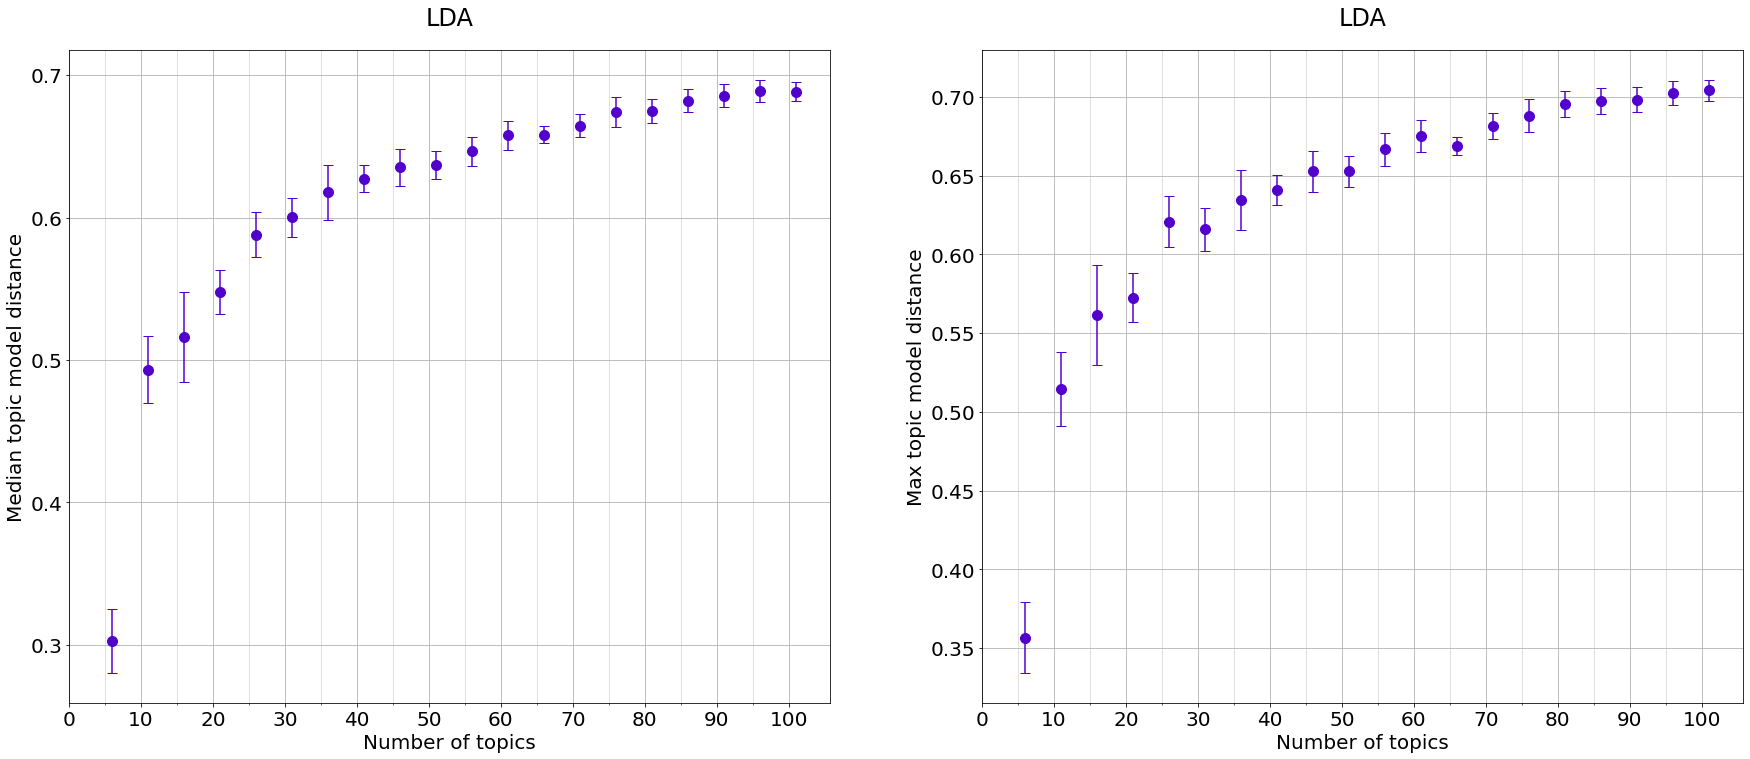

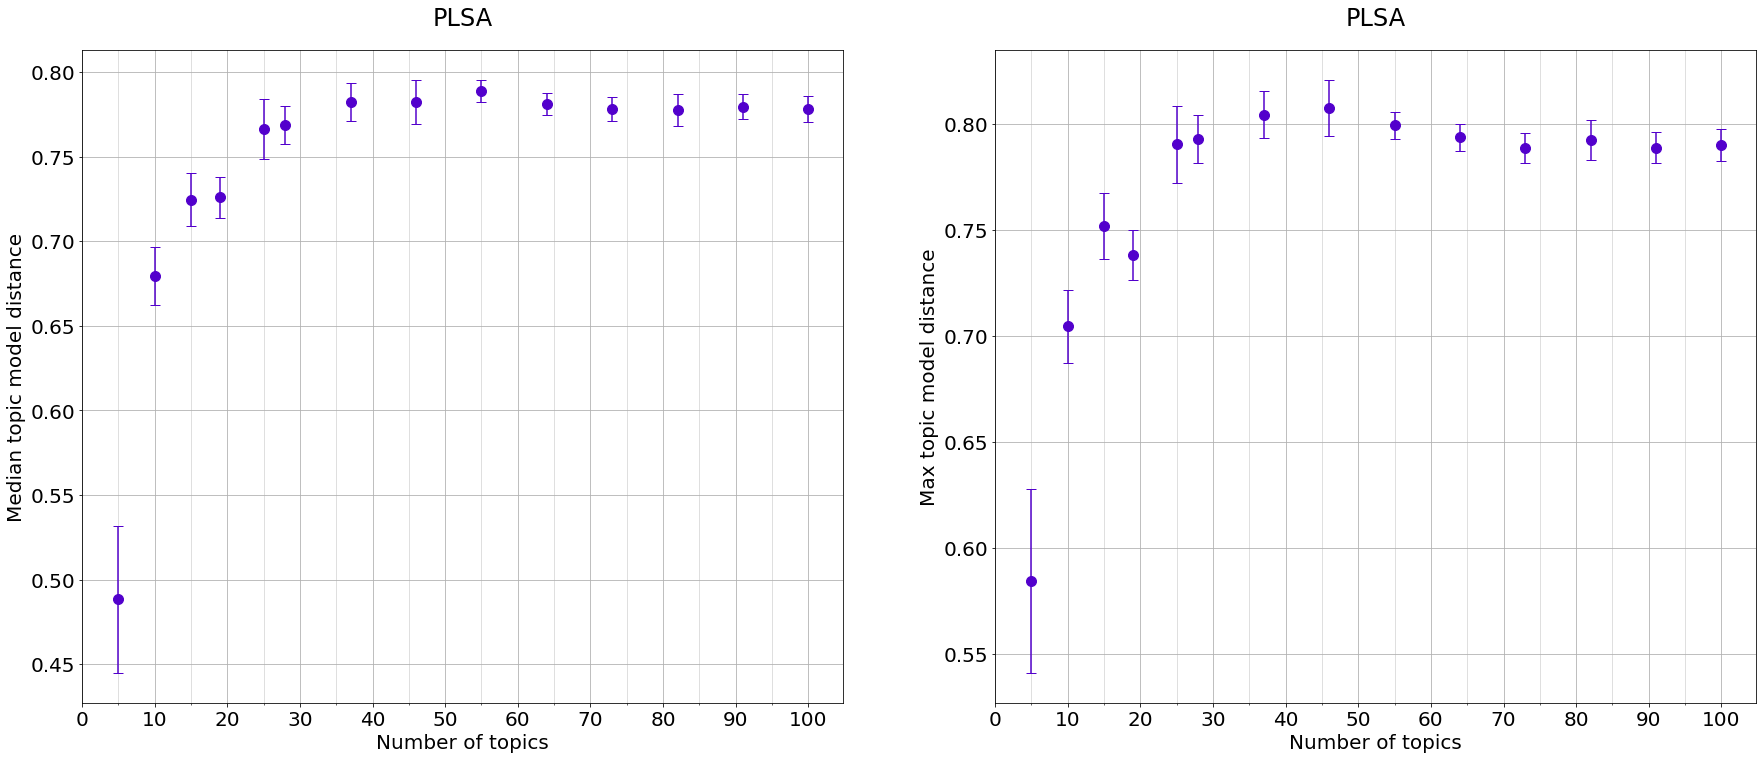

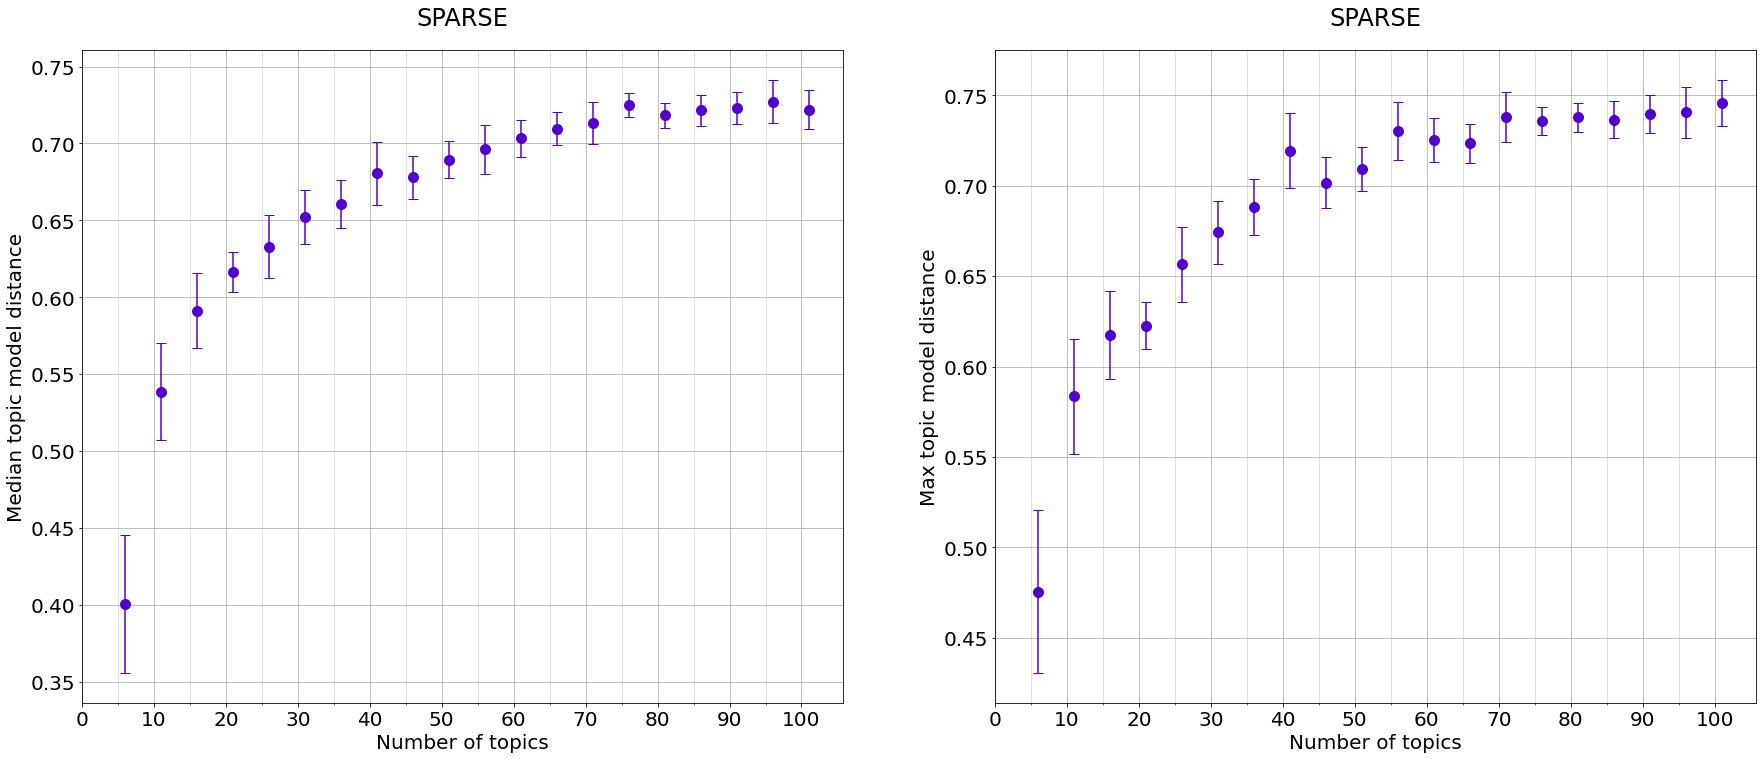

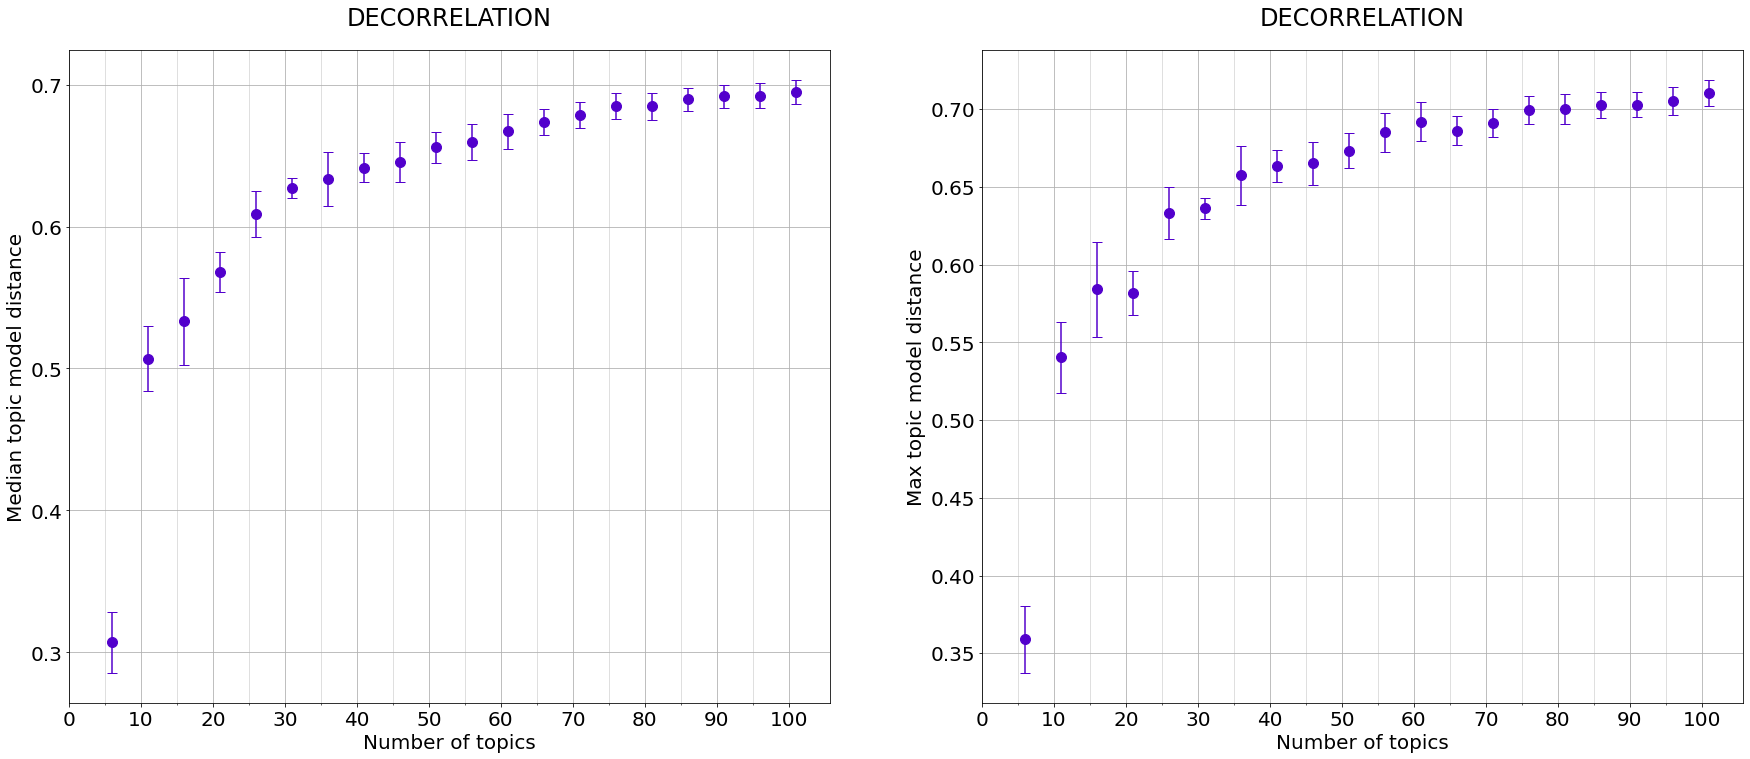

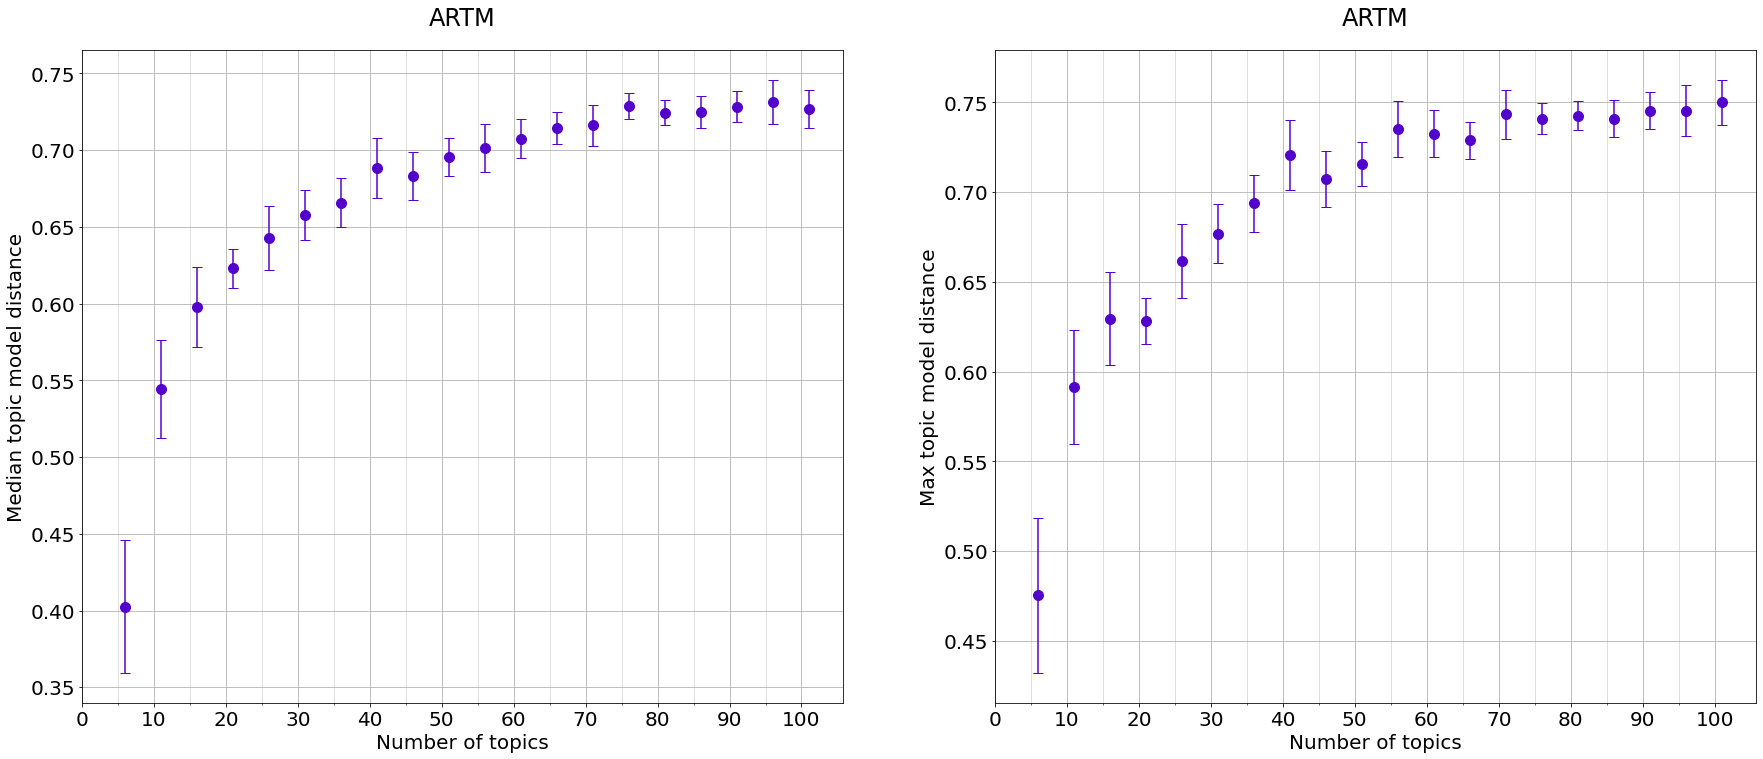

In [ ]:
draw_all_plots(DATASET_NAME_POSTNAUKA)

There are $19$ topics in PostNauka (unbalanced).

If looking on `Max topic model distance` plots:

* `LDA` gives slight local minimum around $30$ and $65$ topics
* `PLSA` — $\mathbf{20}$ topics
* `SPARSE` — $\mathbf{20}$, $45$ and $65$
* `DECORRELATION` — $\mathbf{20}$, $30$ and $65$
* `ARTM` — $\mathbf{20}$, $45$, $65$

### Brown<a id="brown"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

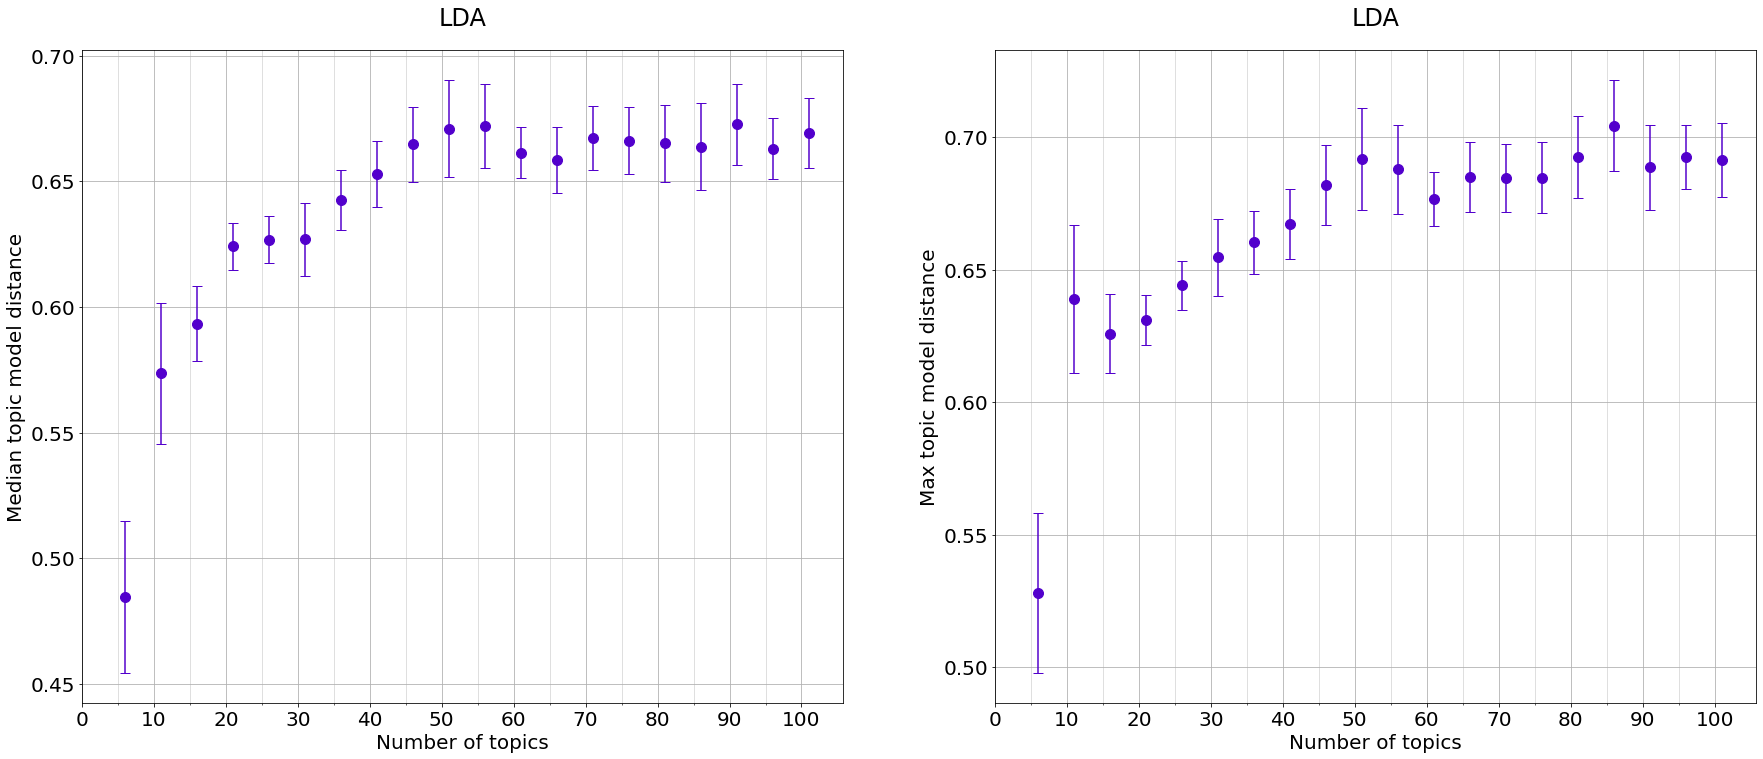

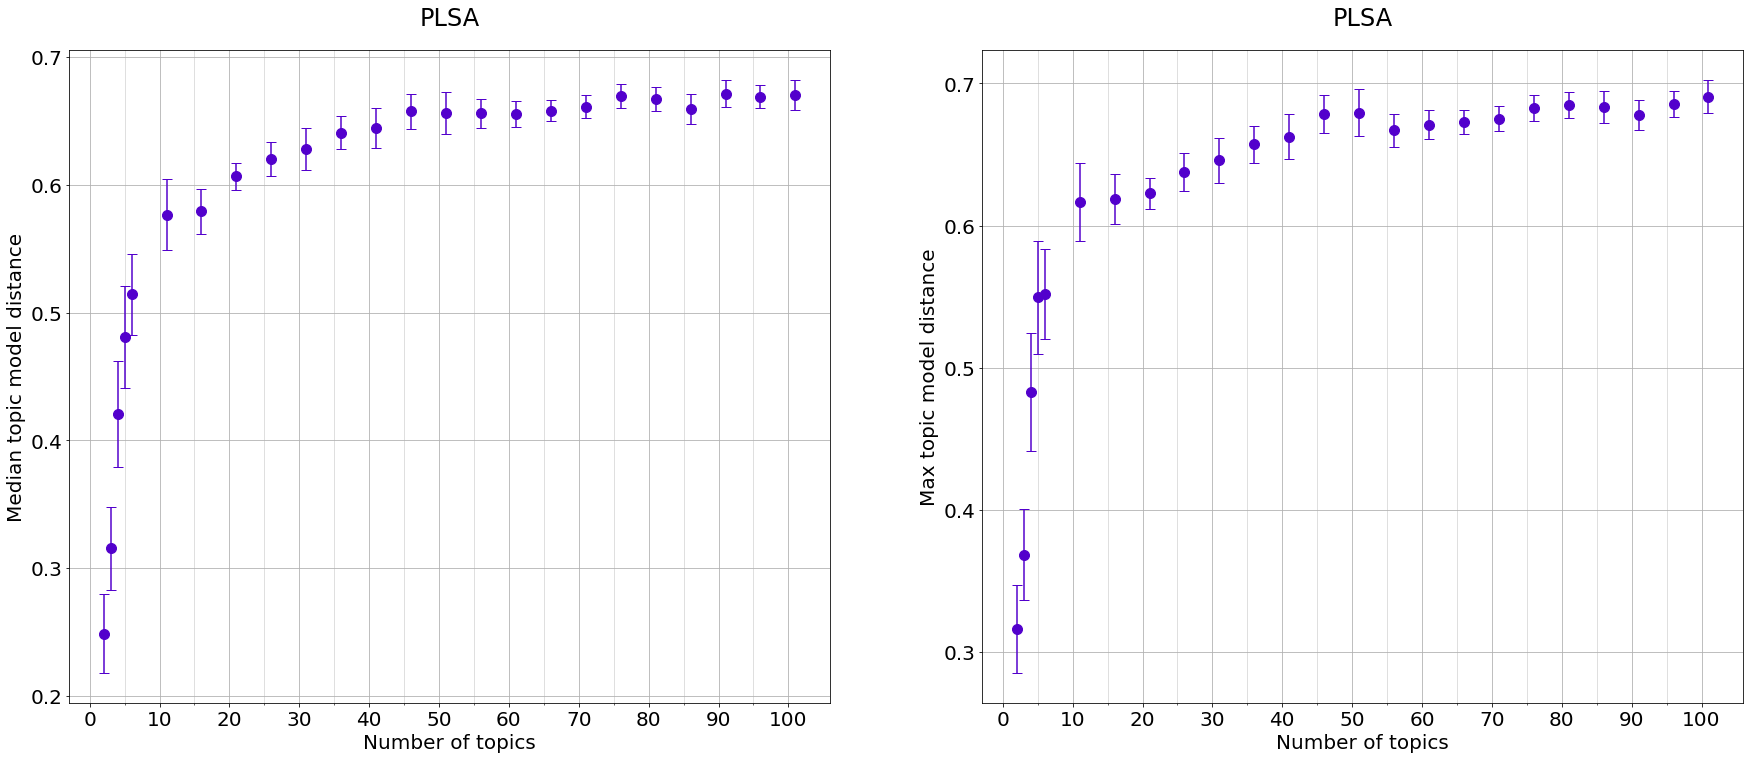

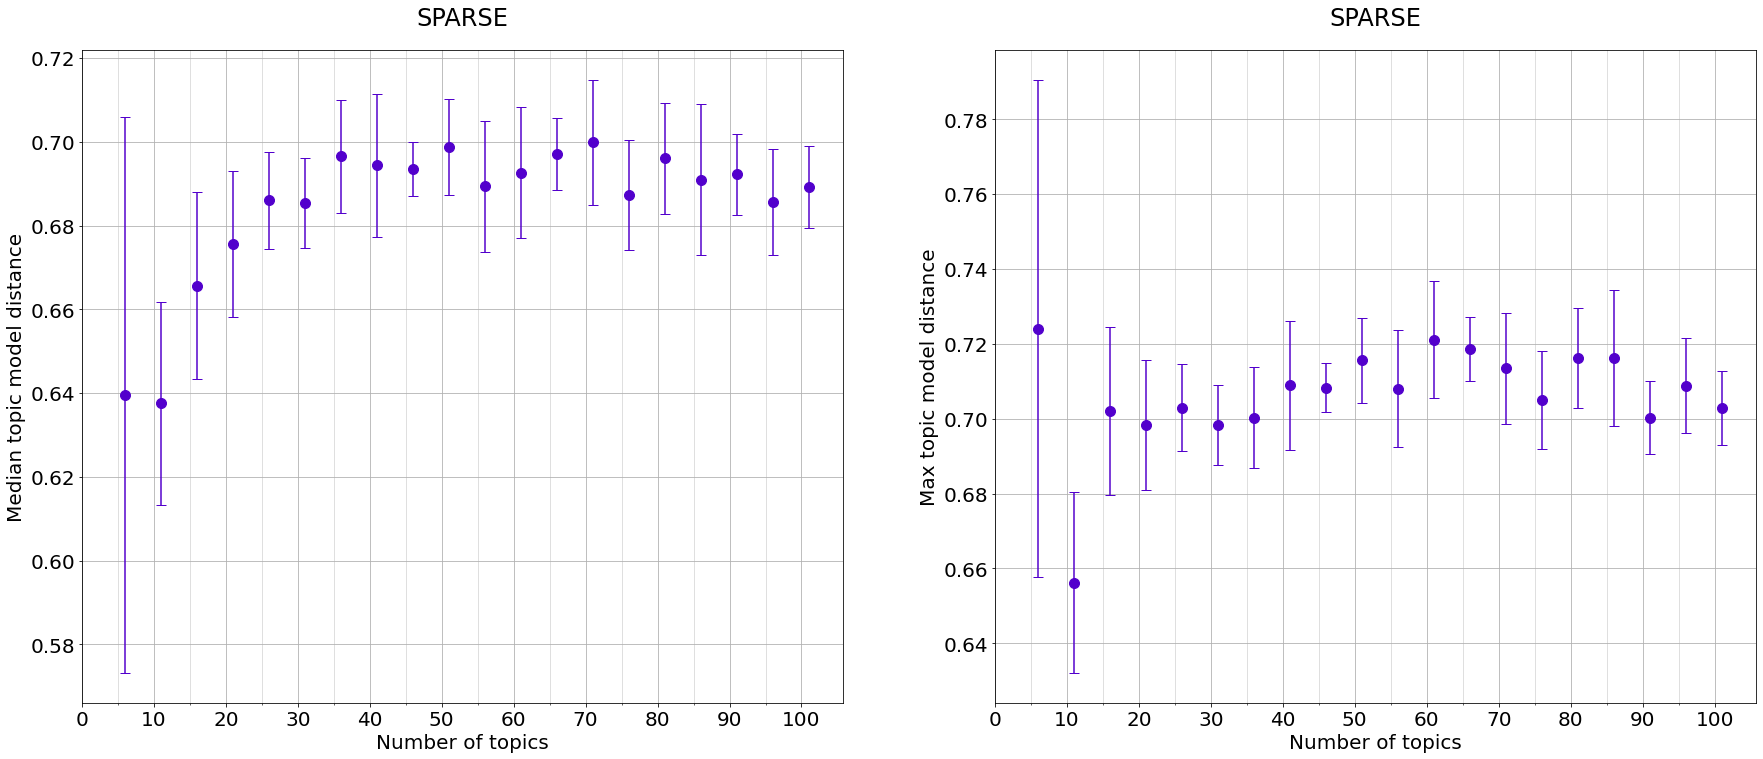

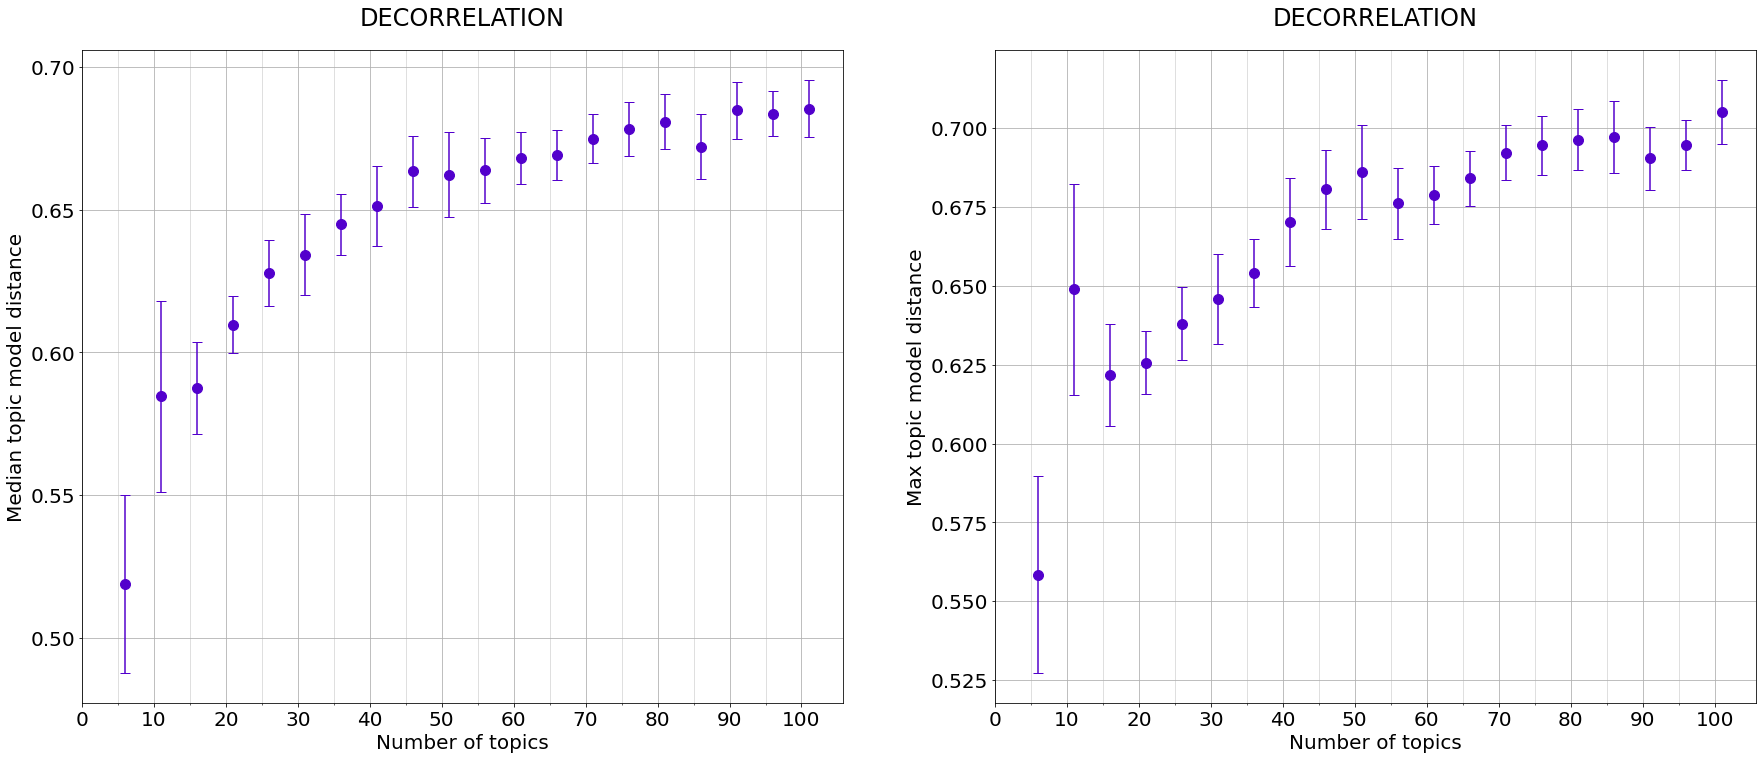

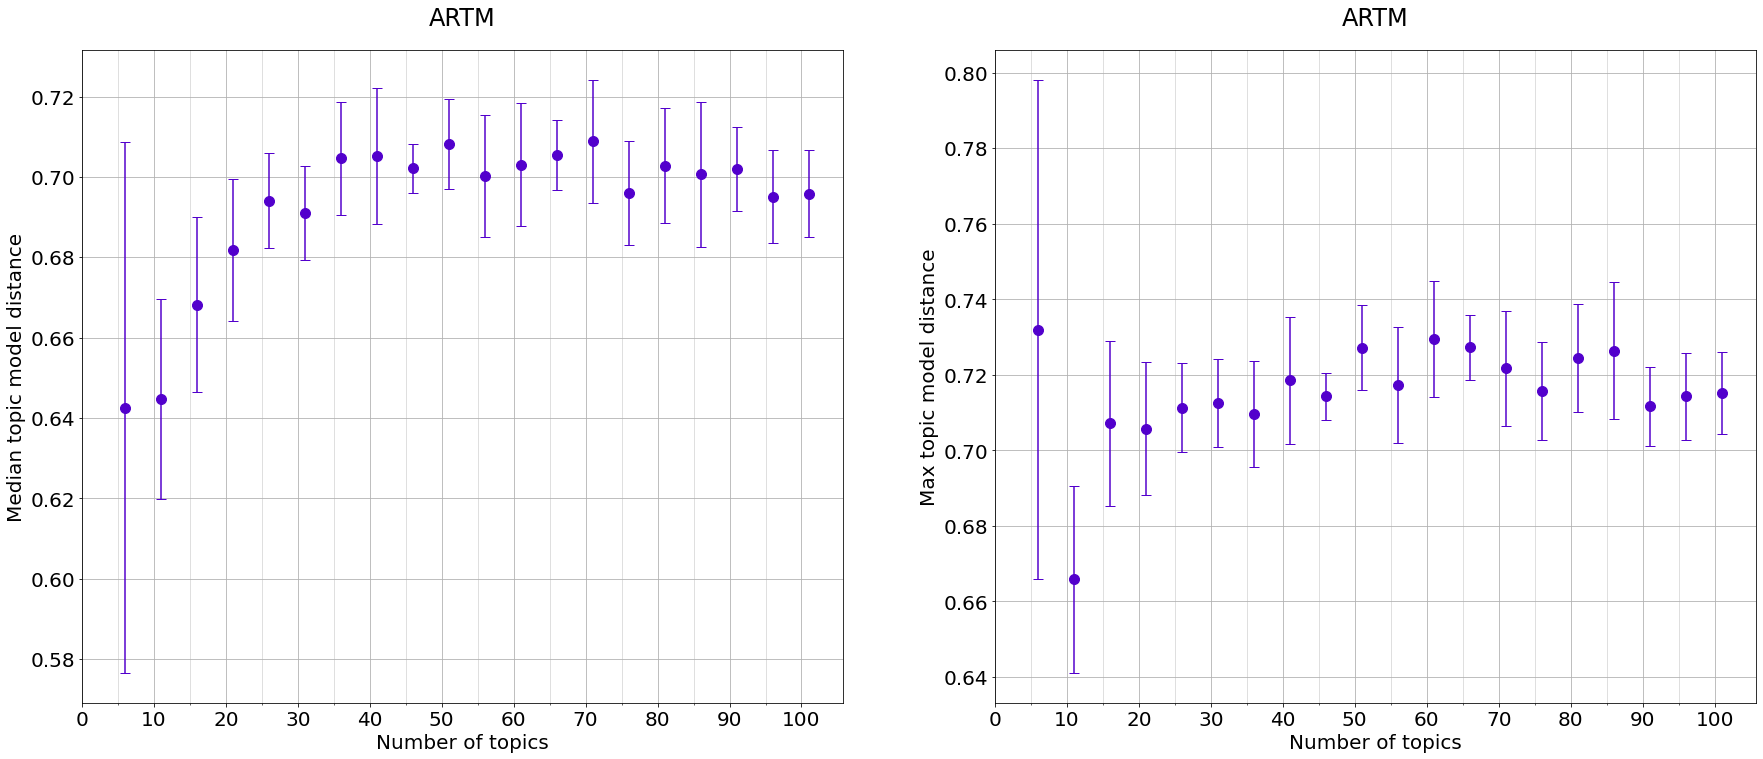

In [ ]:
draw_all_plots(DATASET_NAME_BROWN)

There are $15$ topics in Brown (also unbalanced).

Local minimums:
* `LDA` — $\mathbf{15}$, $60$, $90$
* `PLSA` — $\mathbf{15}$, $55$, $90$
* `SPARSE` — $10$, $30$, $75$
* `DECORRELATION` — $\mathbf{15}$, $55$, $90$
* `ARTM` — $10$, $75$, $90$

### Twenty Newsgroups<a id="twenty-newsgroups"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

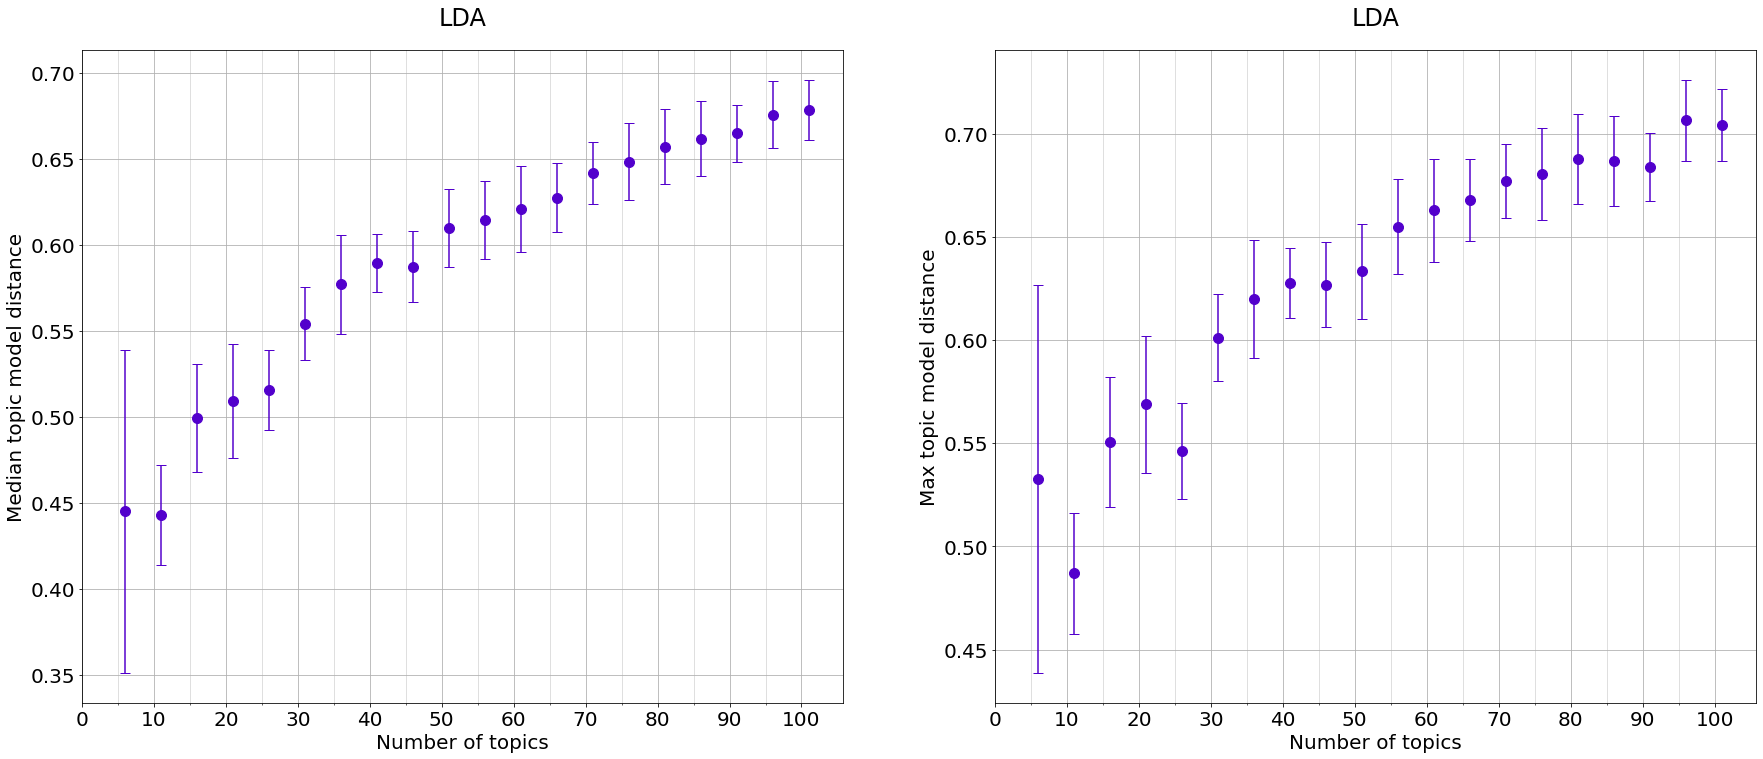

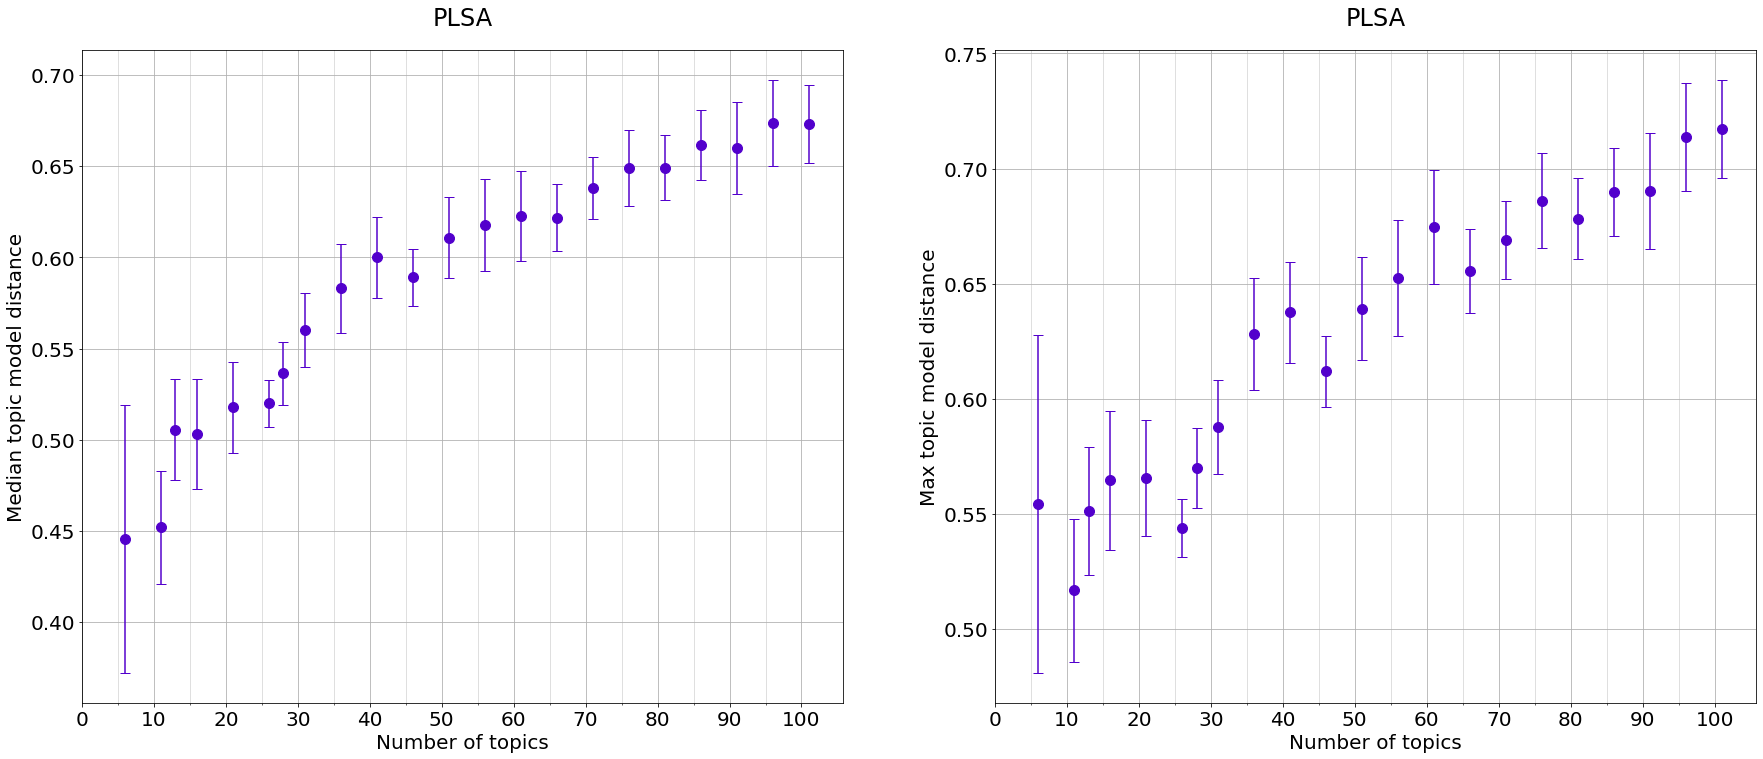

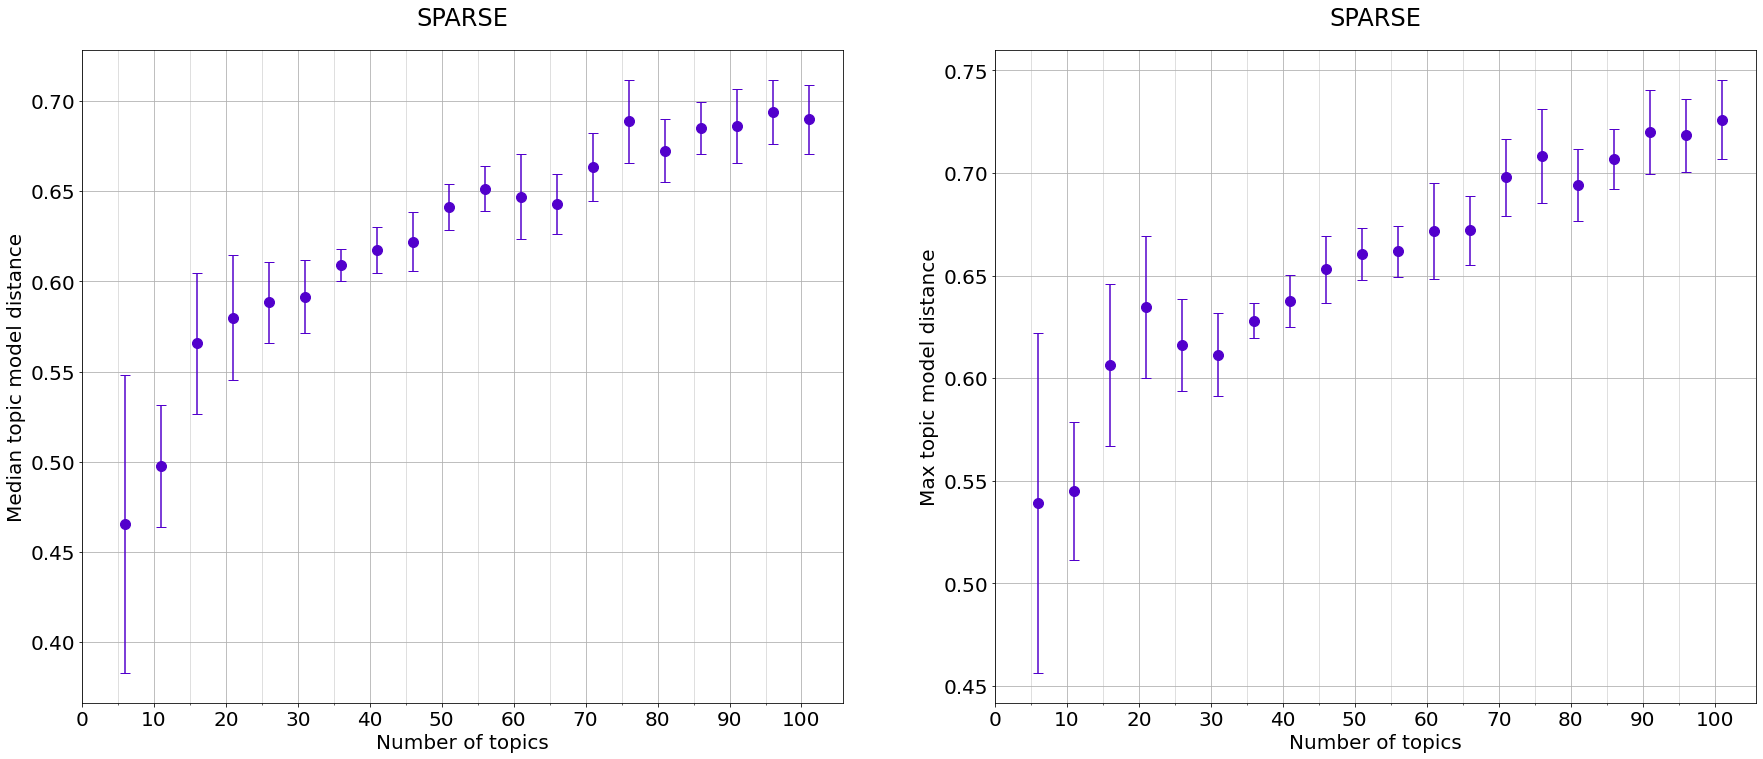

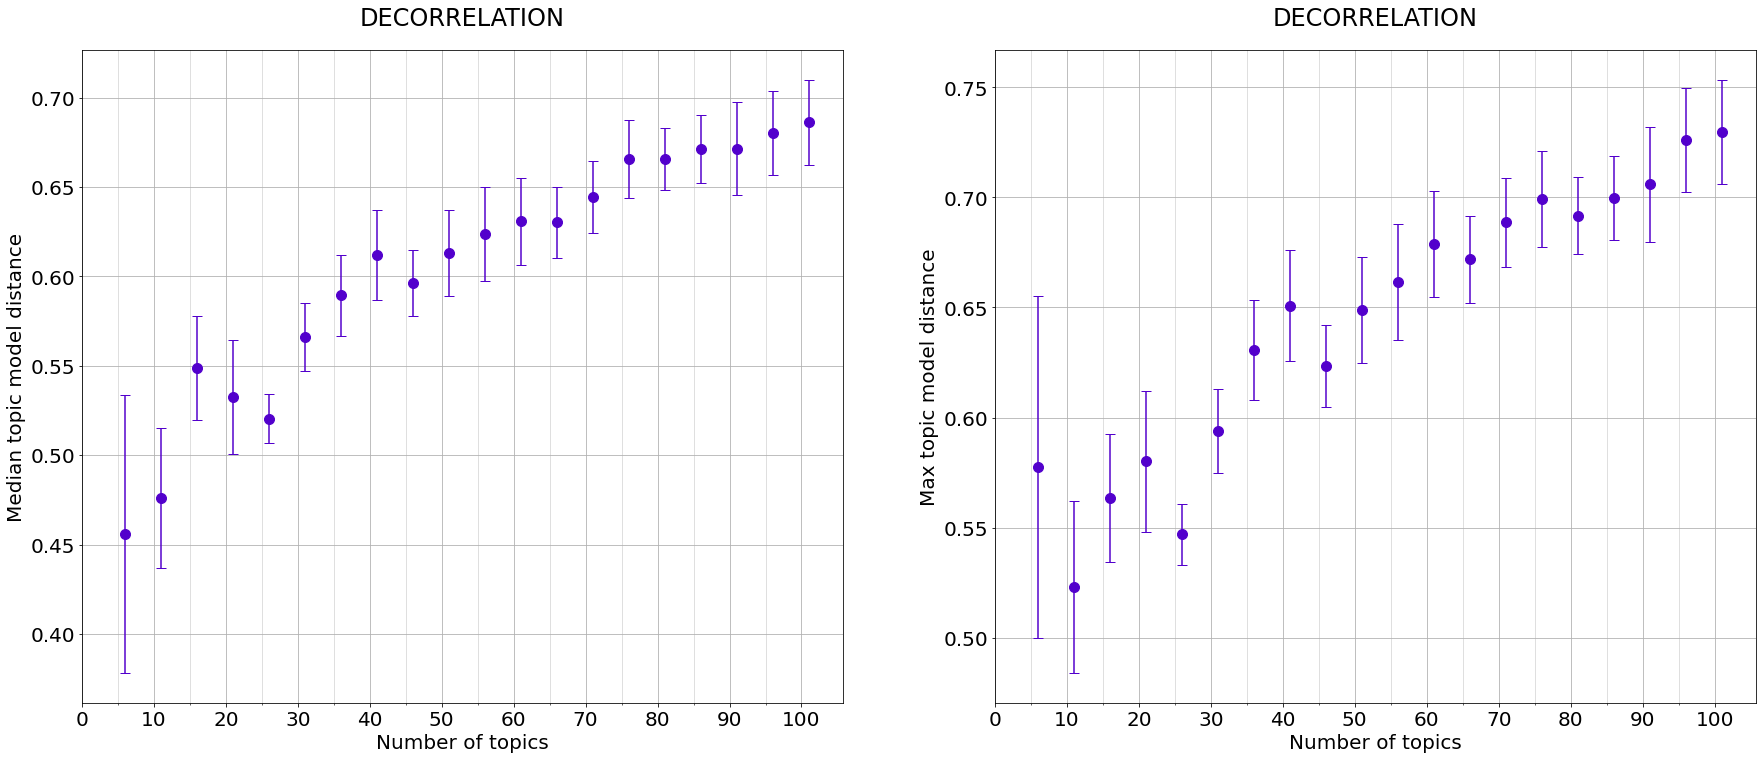

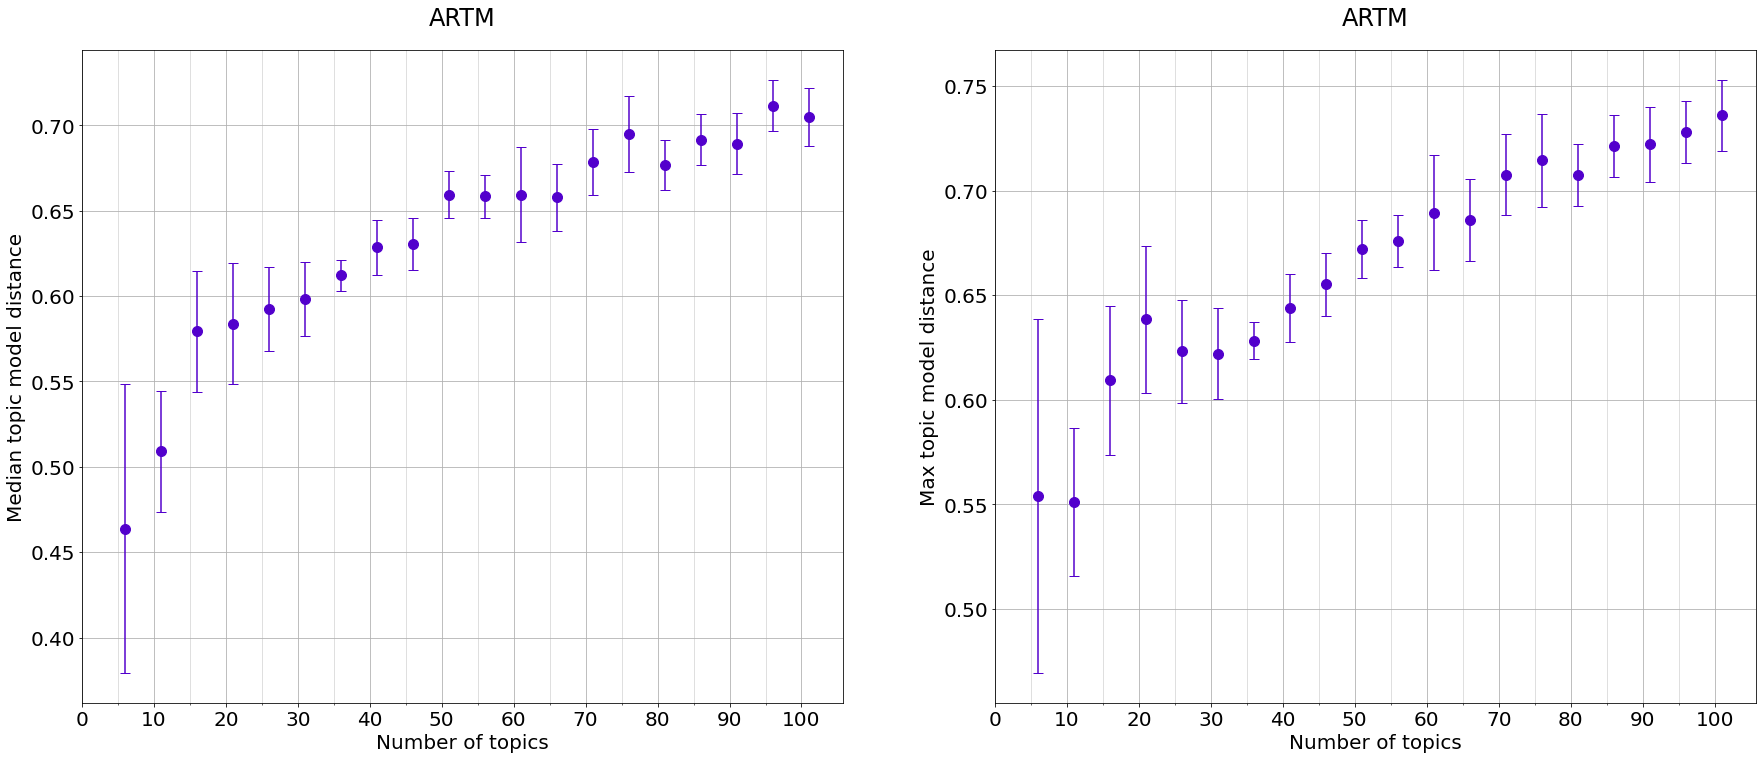

In [ ]:
draw_all_plots(DATASET_NAME_TWENTY_NEWSGROUPS)

There are apparently $20$ topics in 20 Newsgroups.

Local minimums:
* `LDA` — $10$, $25$, $45$, $90$
* `PLSA` — $25$, $45$, $65$, $80$
* `SPARSE` — $30$, $80$
* `DECORRELATION` — $10$, $25$, $45$, $65$, $80$
* `ARTM` — $10$, $30$, $65$, $80$

$30$ is very distinct for all models

### Reuters<a id="reuters"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

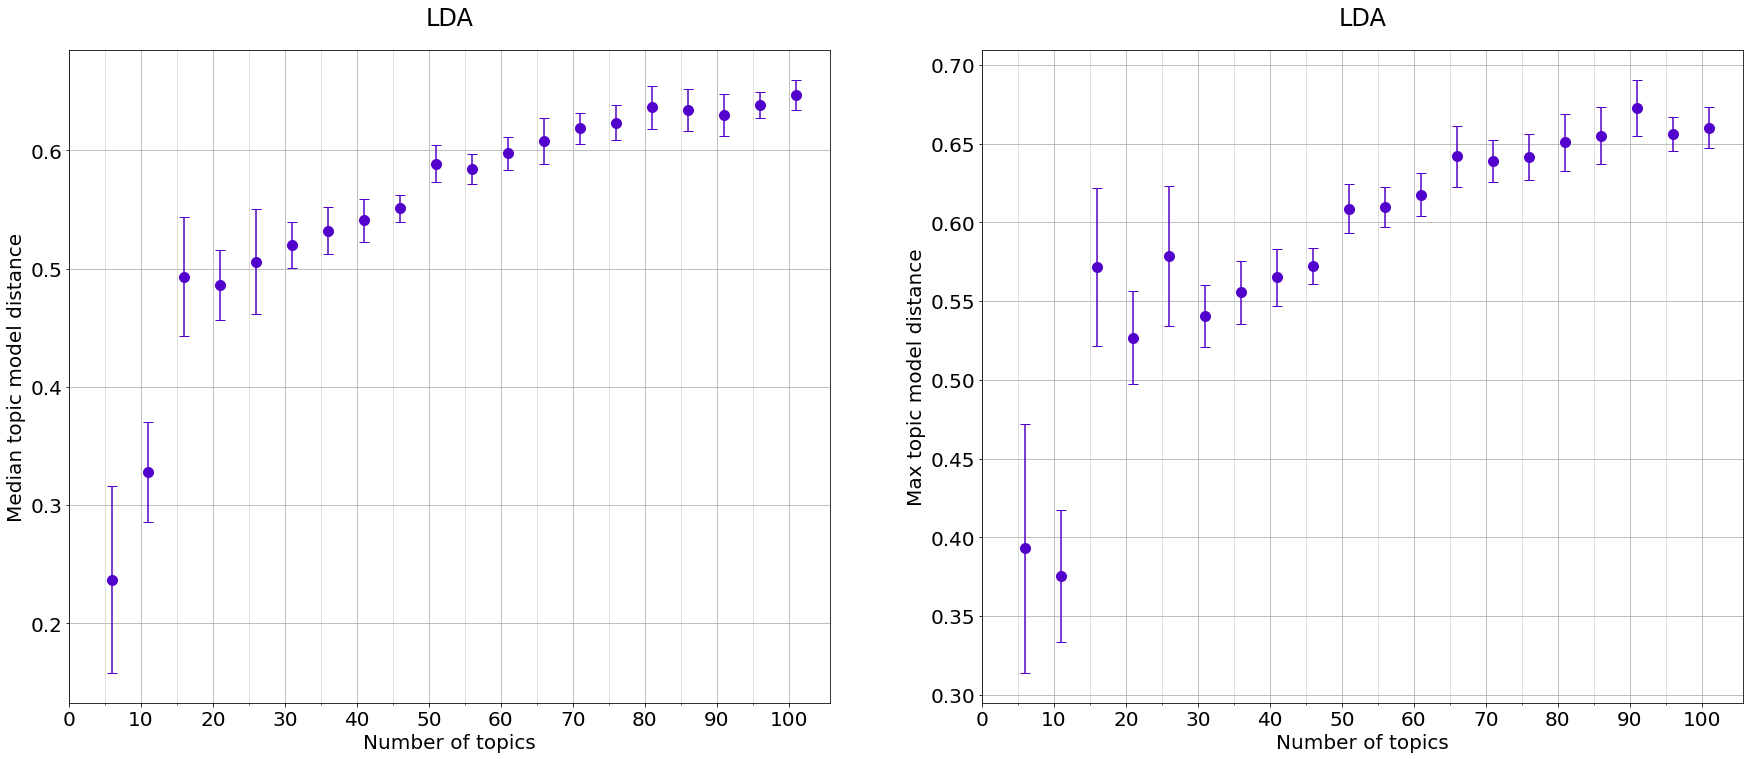

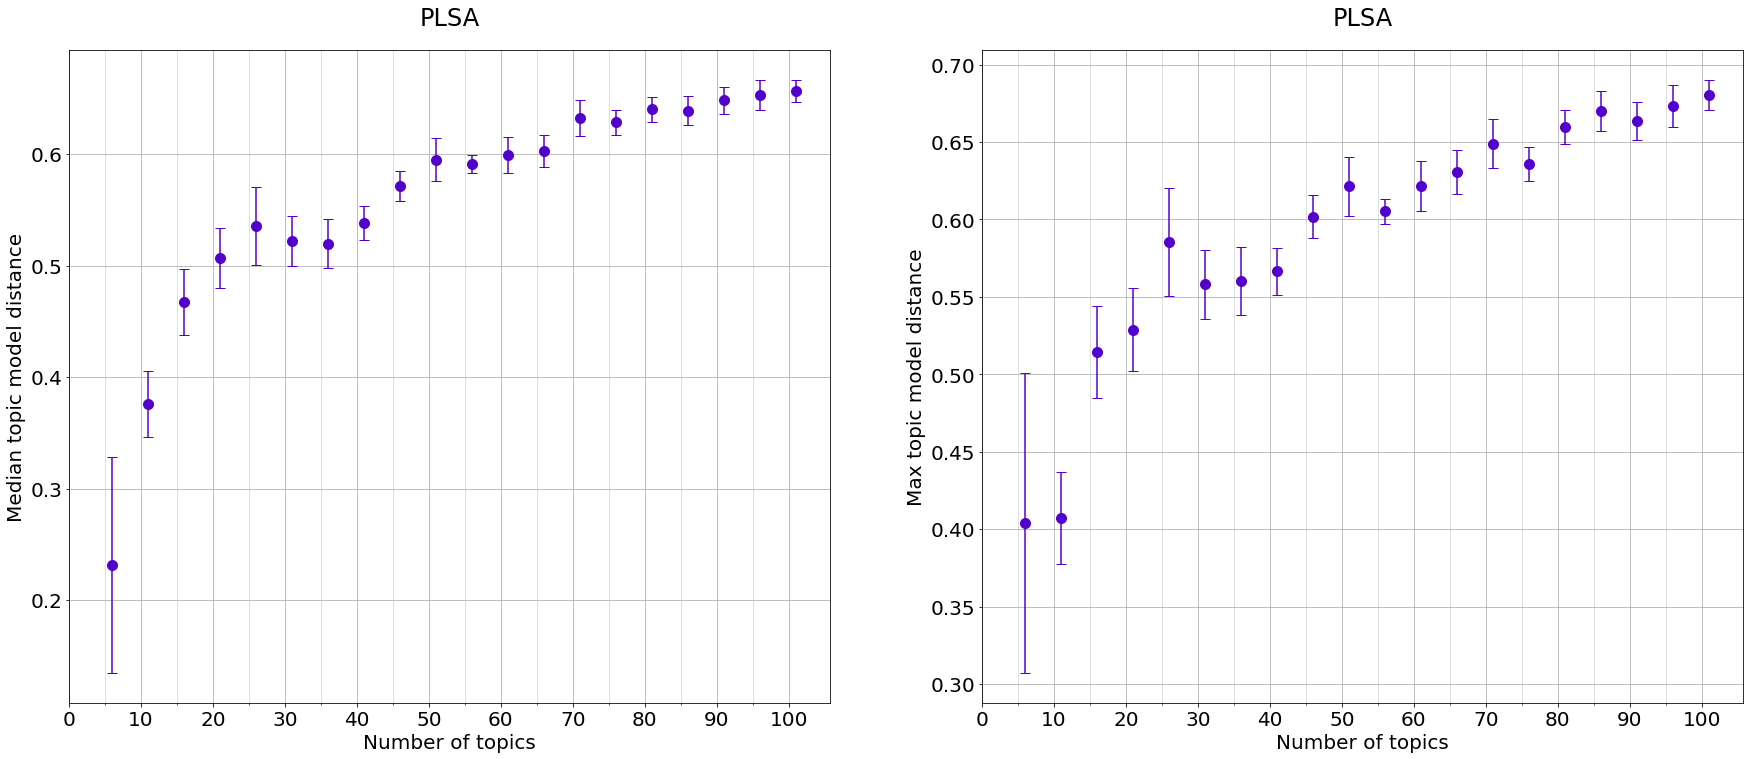

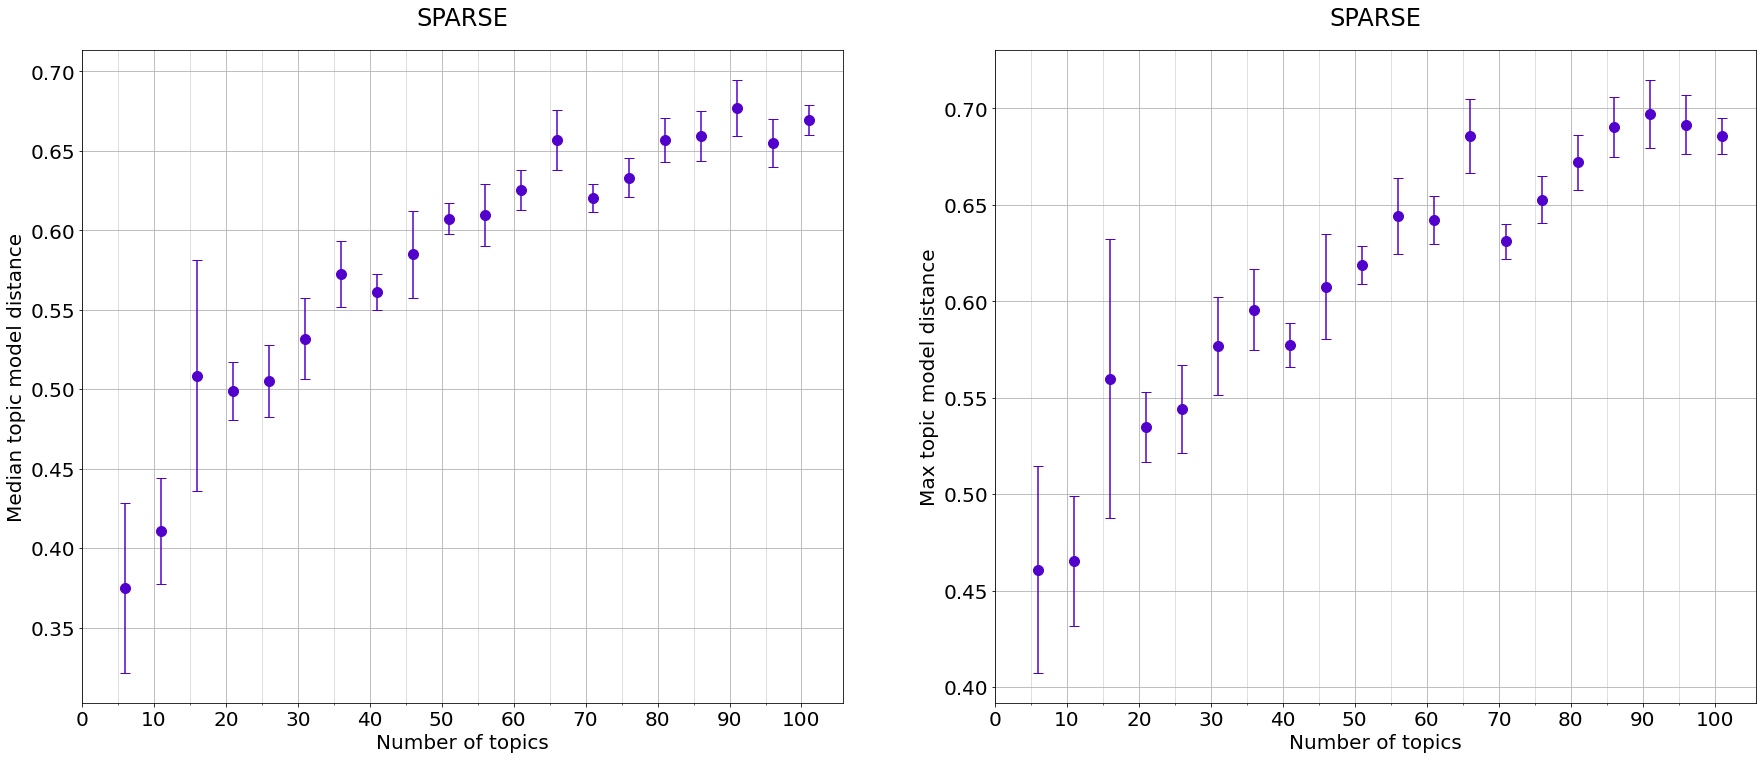

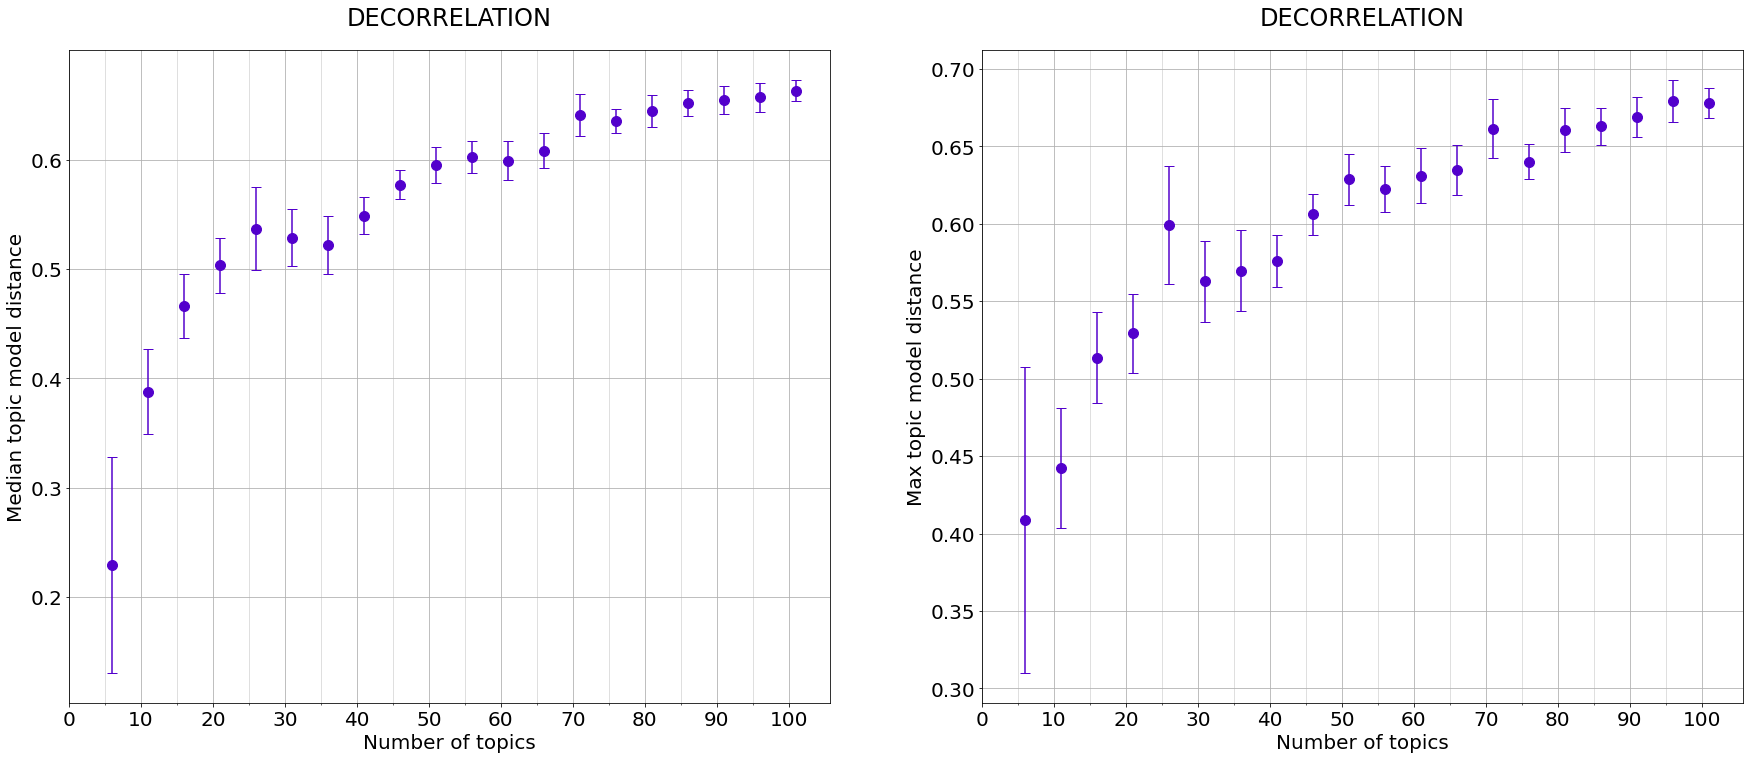

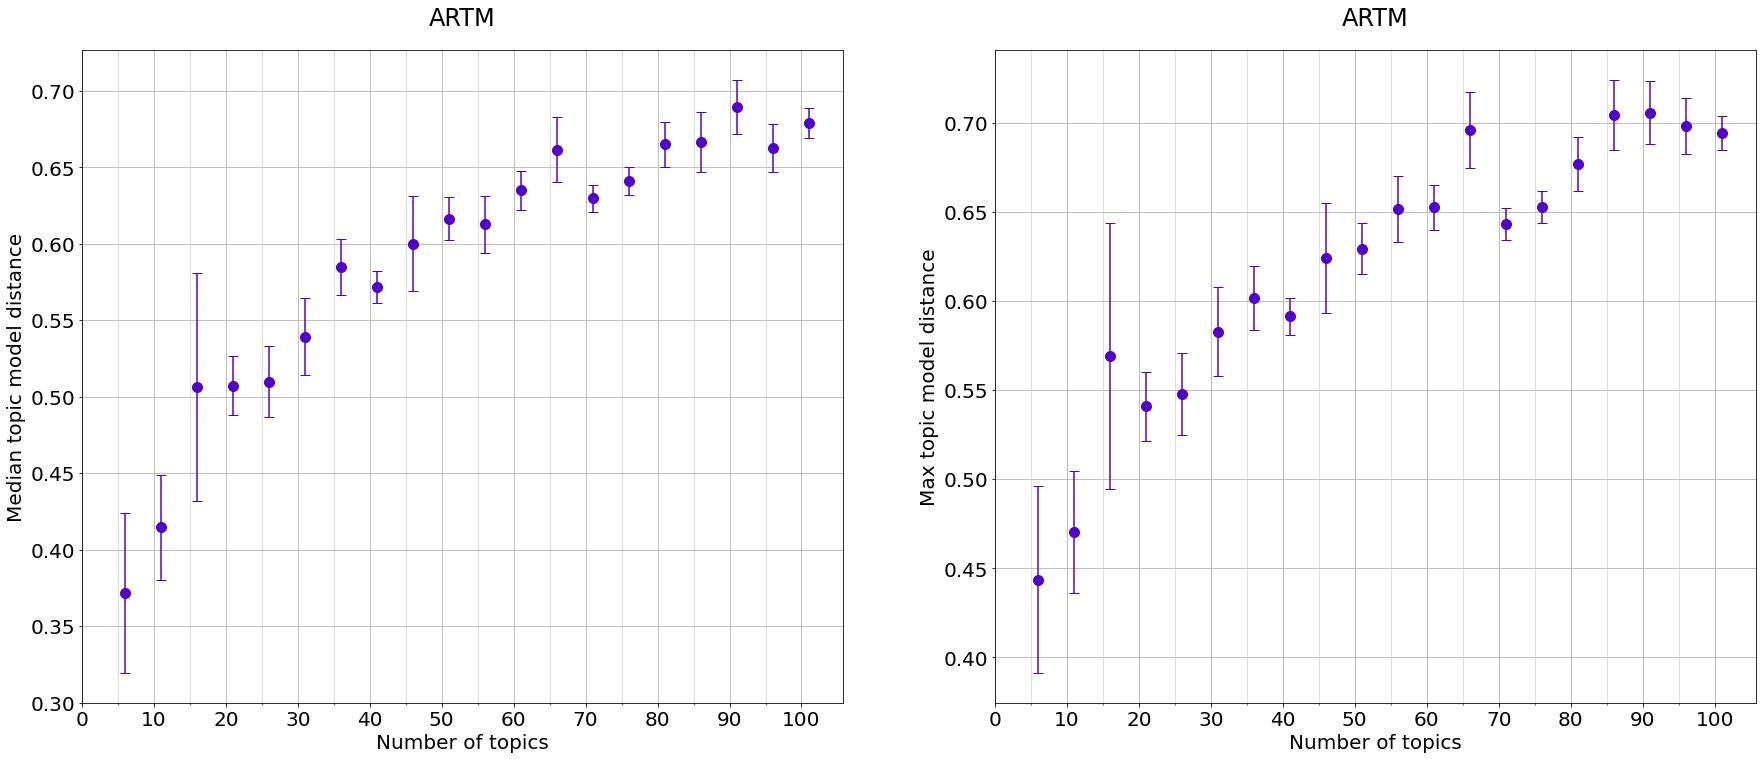

In [ ]:
draw_all_plots(DATASET_NAME_REUTERS)

There are $90$ topics in Reuters (but it is highly unbalanced: only $21$ topics has $100$ or more documents).

Local minimums:
* `LDA` — $20$, $30$
* `PLSA` — $30$, $55$, $75$
* `SPARSE` — $20$, $40$, $70$
* `DECORRELATION` — $30$, $75$
* `ARTM` — $20$, $40$, $70$

`SPARSE` and `ARTM`: very distinct minimum $70$. `PLSA` is like a clear *stairway* (hierarchy?..).

### WikiRef220<a id="wikiref"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

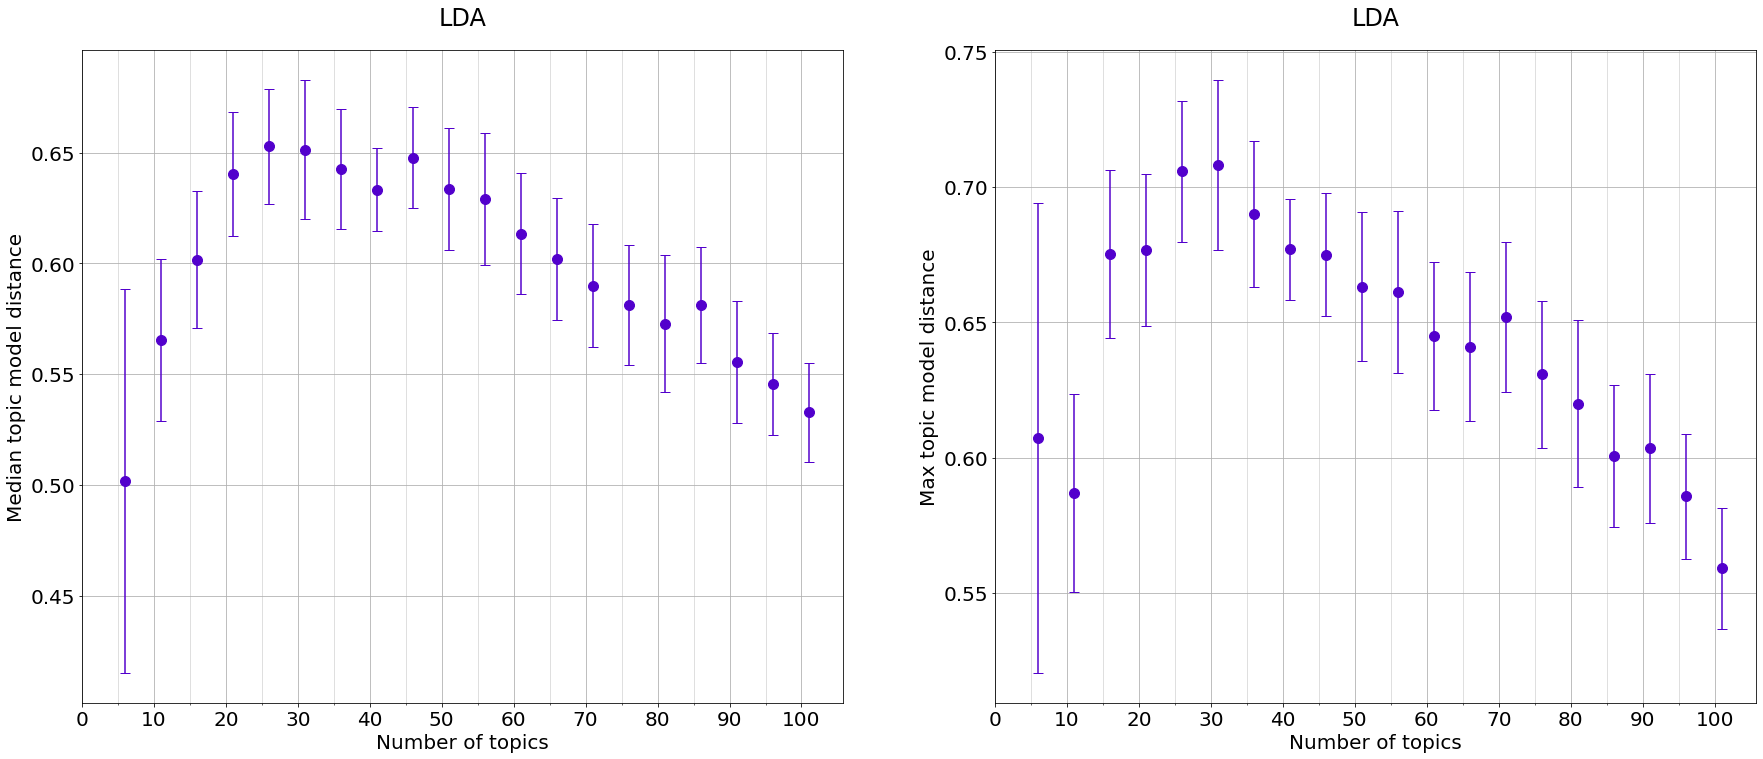

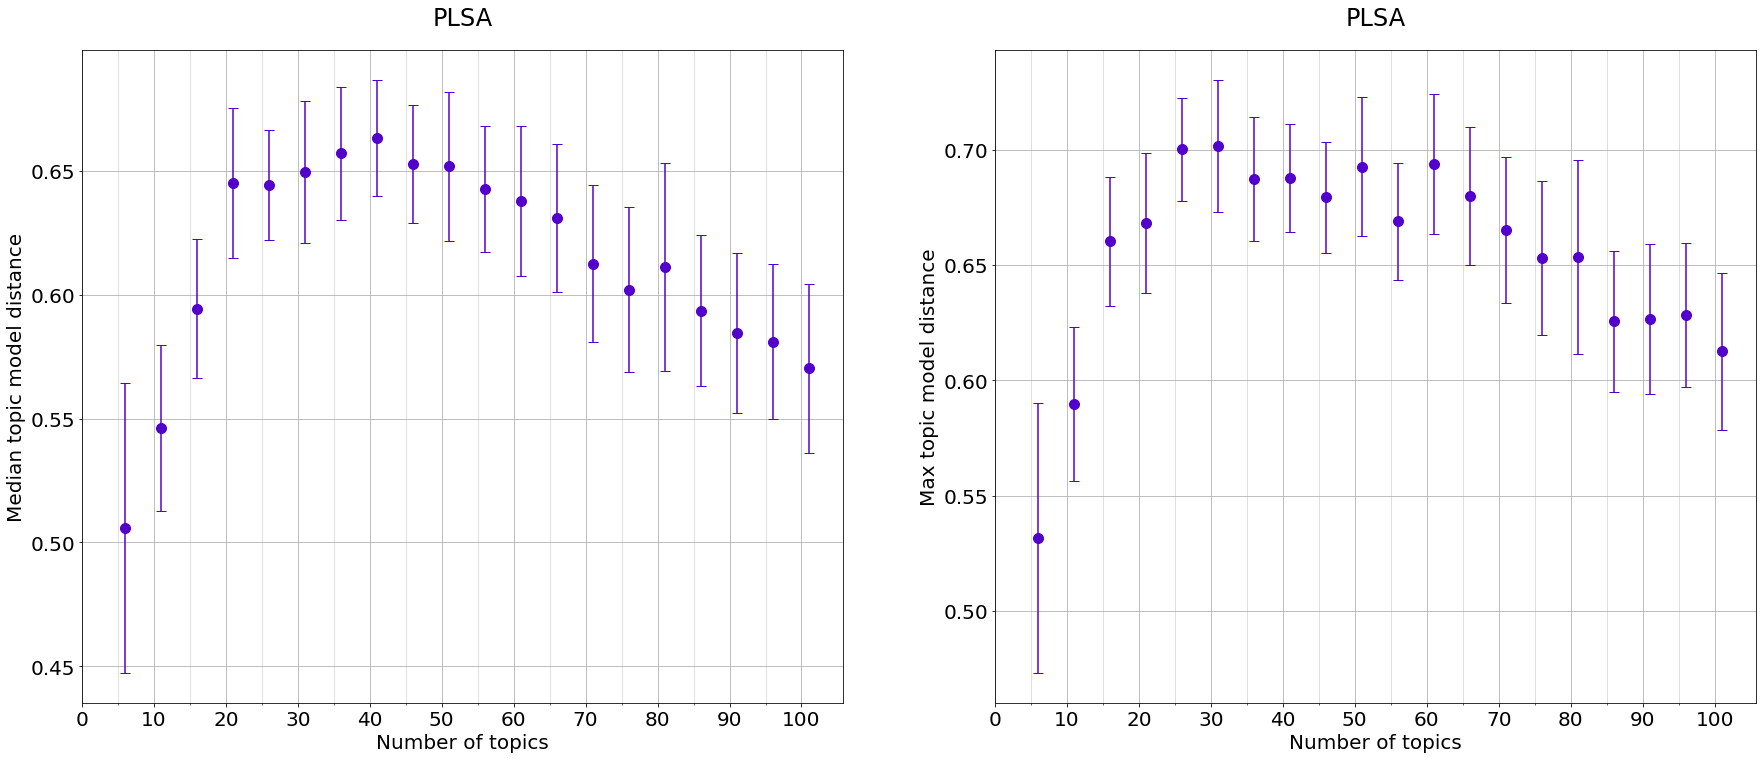

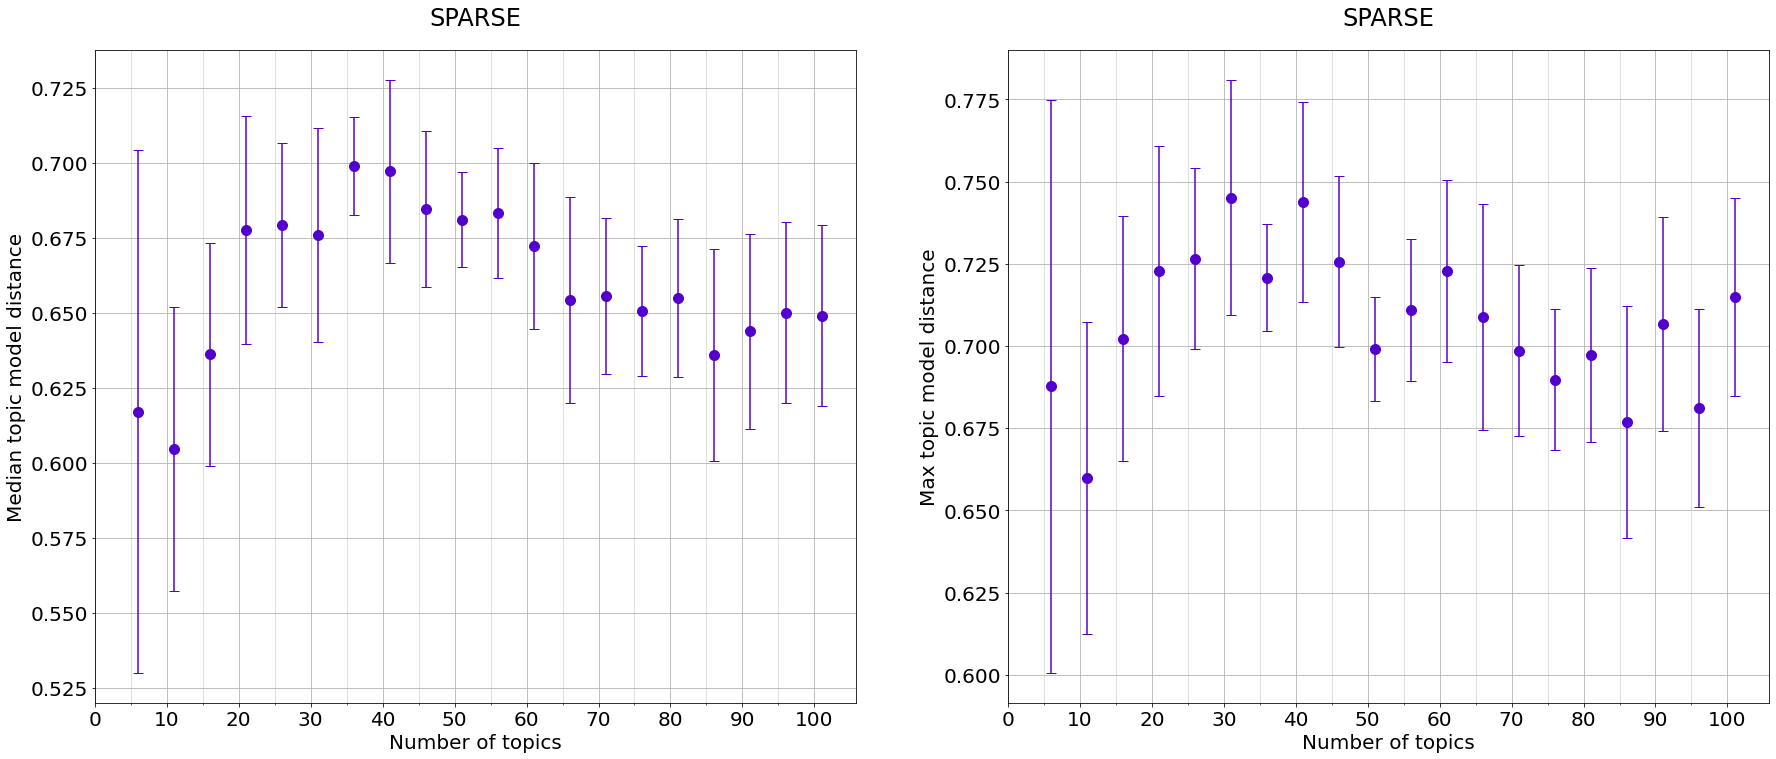

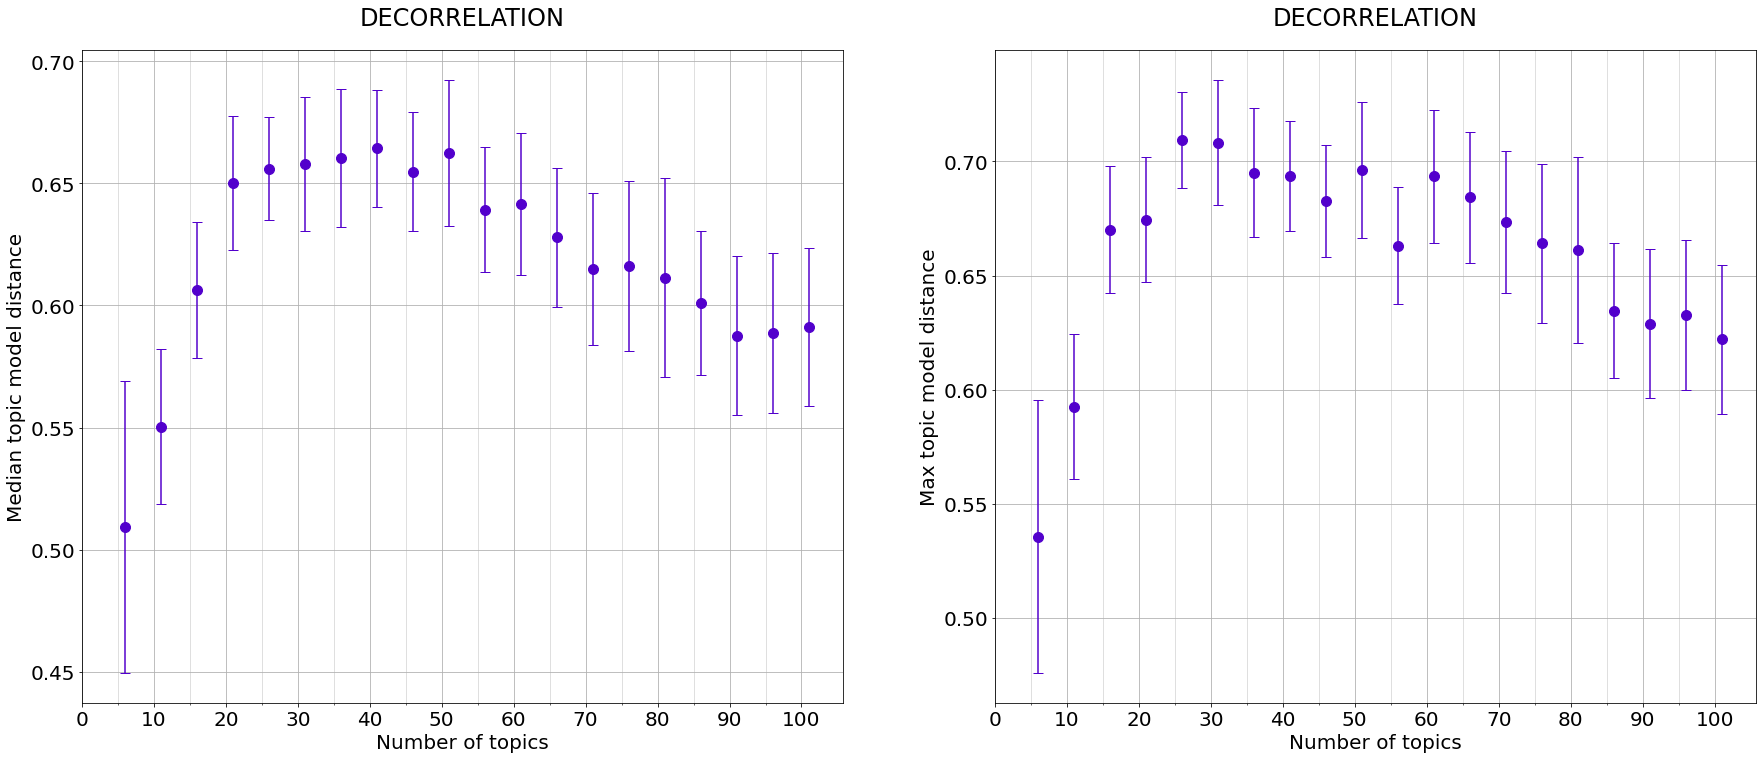

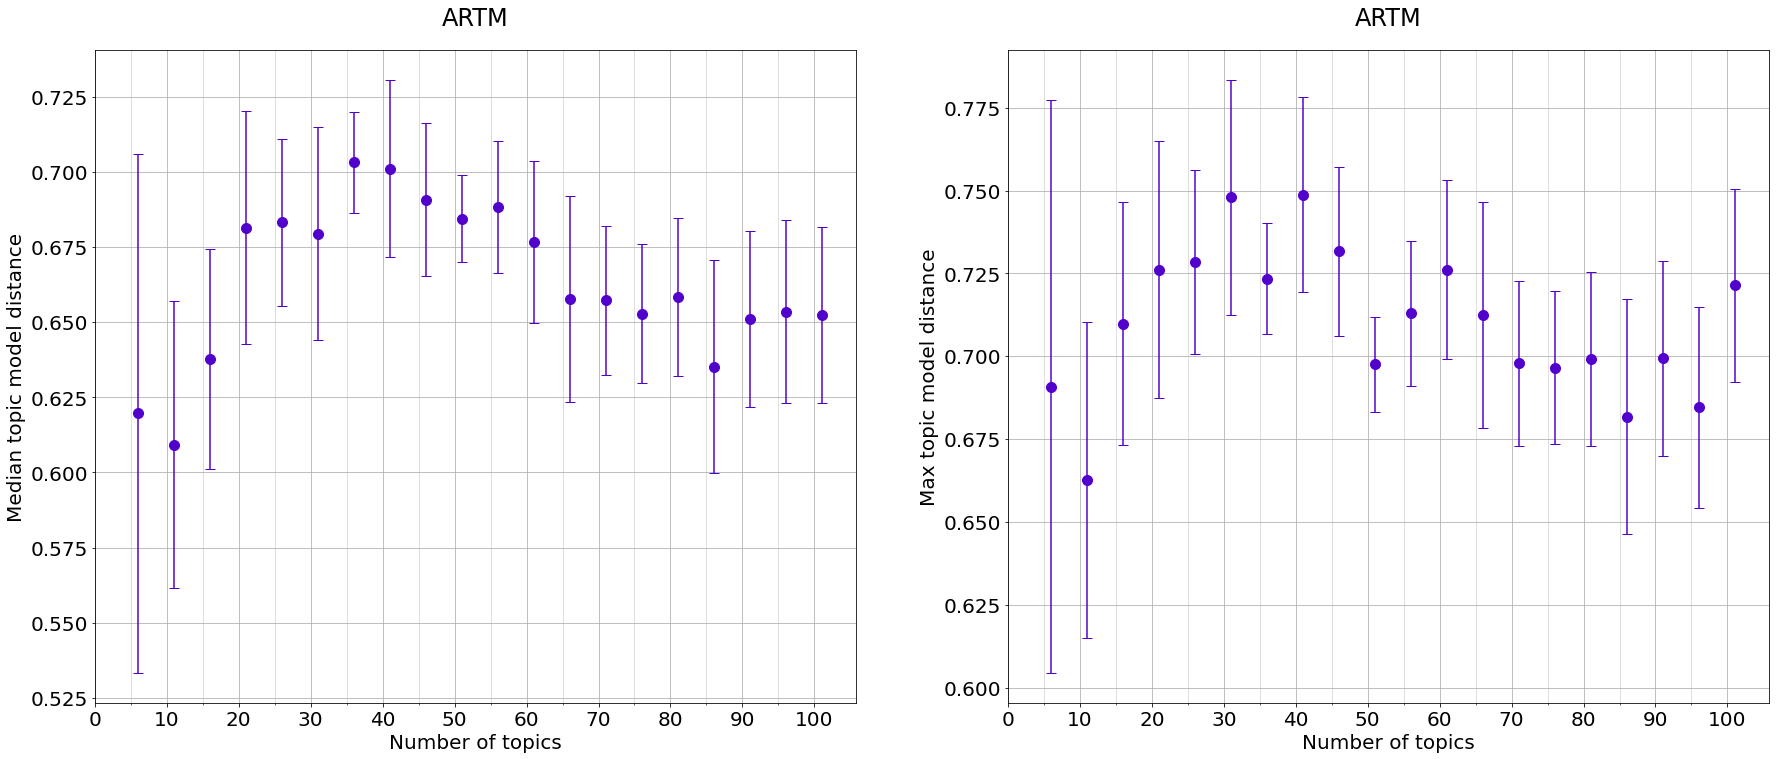

In [ ]:
draw_all_plots(DATASET_NAME_WIKIREF)

Seems interesting: metrics for nearly all models (except `SPARSE` and `ARTM`) reached maximum around $40$-$50$ topics, then there is a steady decline

### Good RU Wiki<a id="good-ru-wiki"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

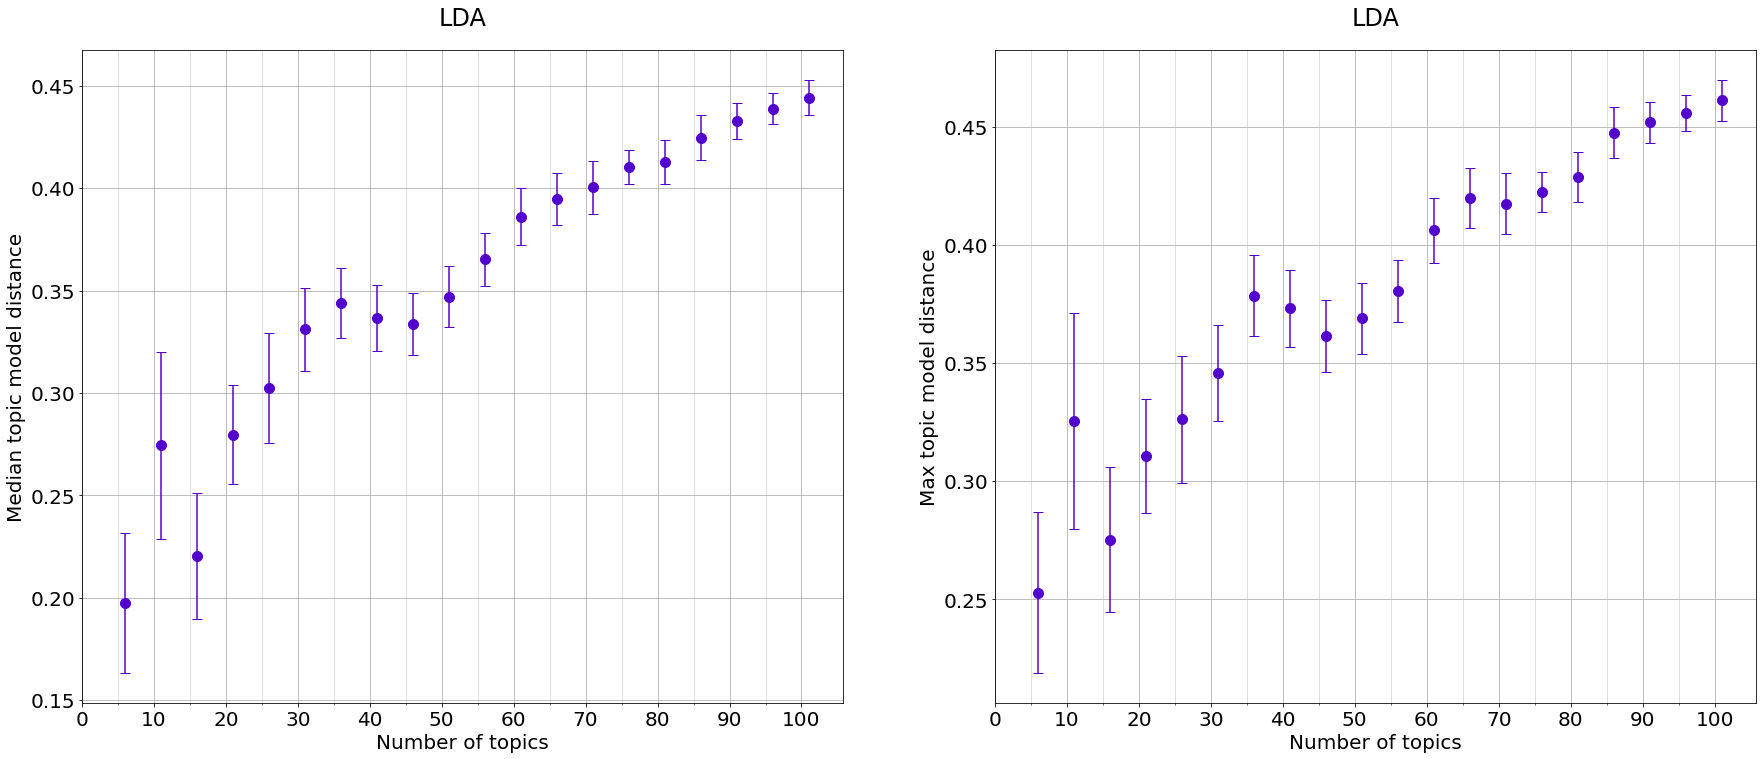

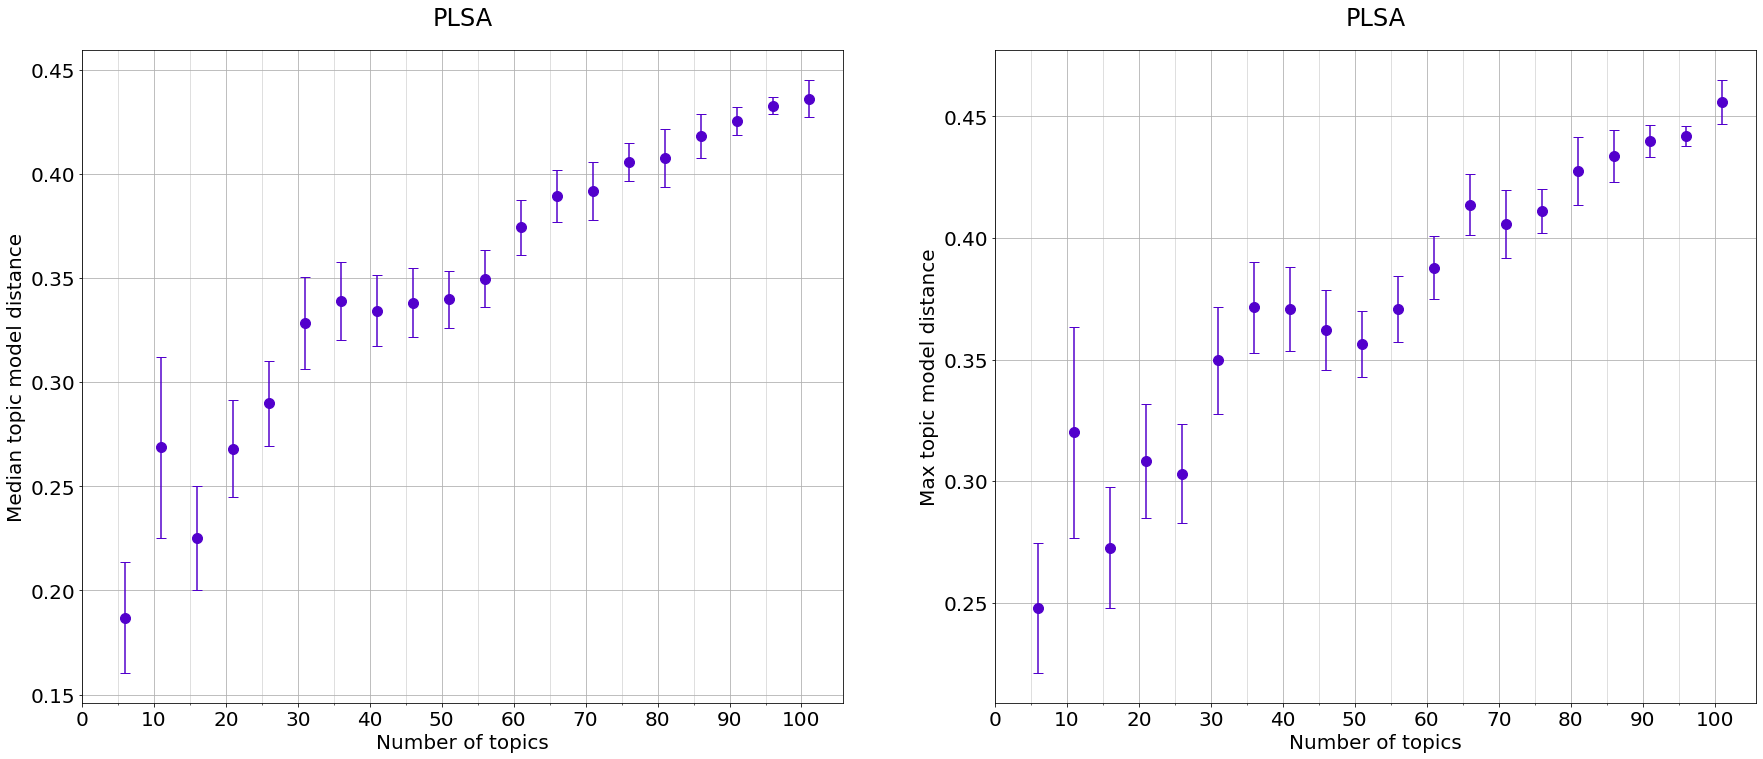

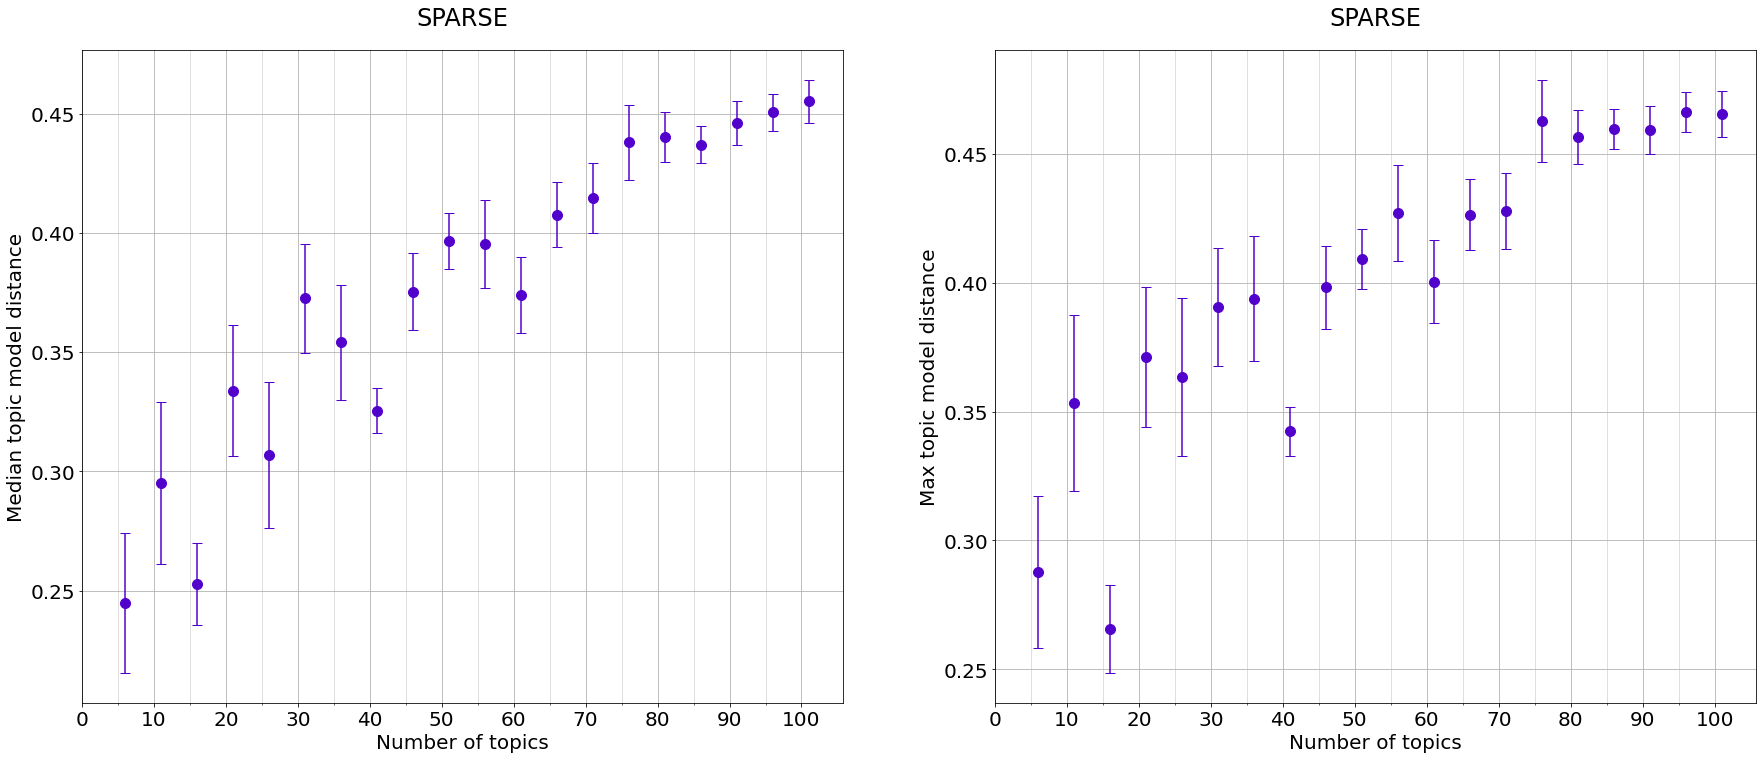

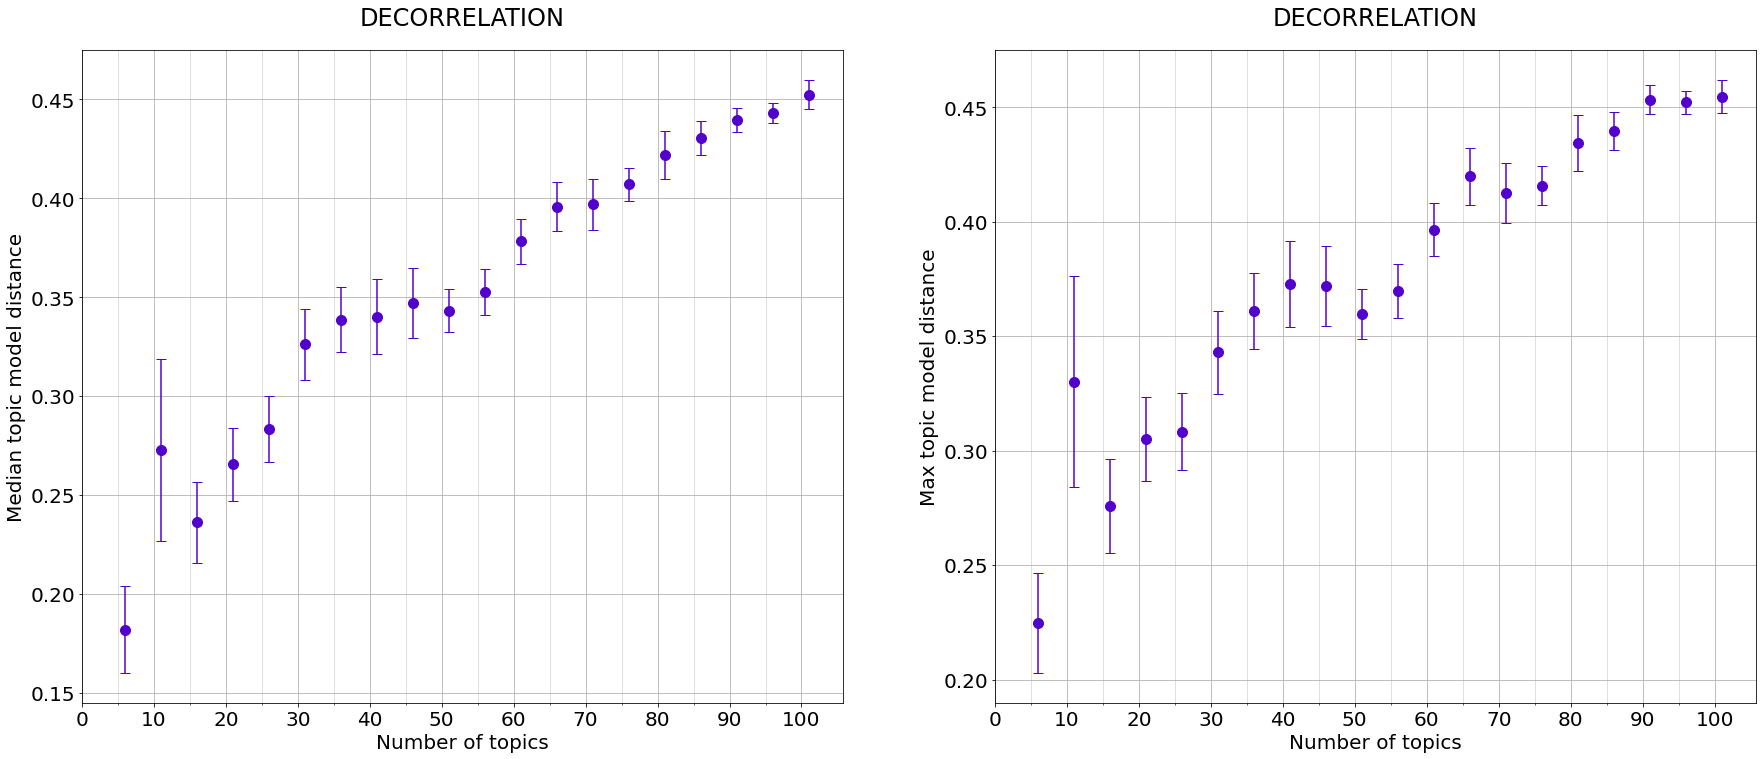

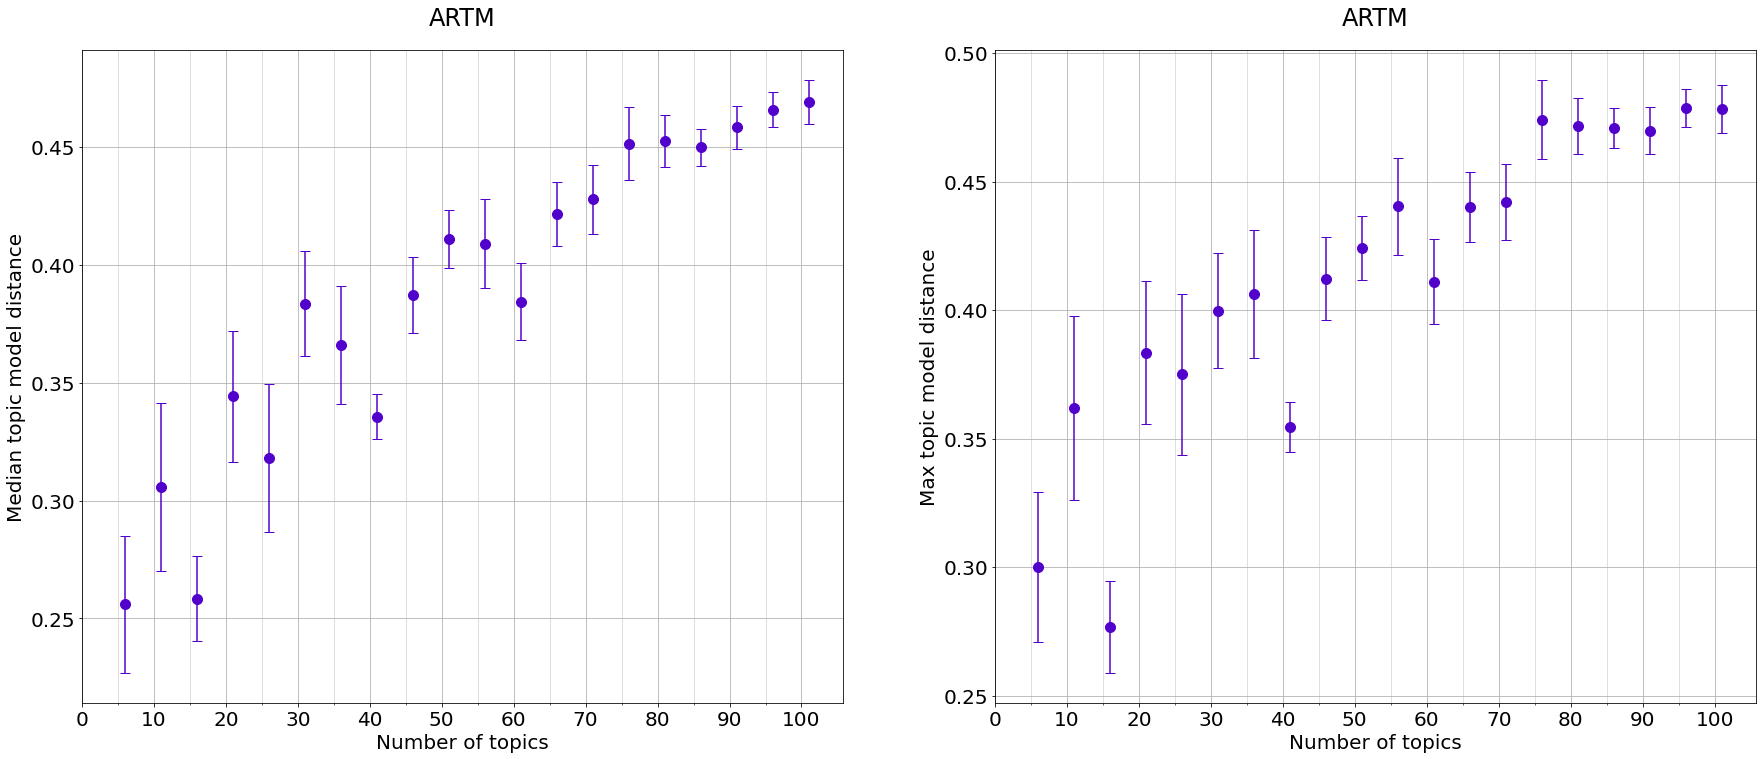

In [ ]:
draw_all_plots(DATASET_NAME_GOOD_RU_WIKI)

# draw_all_plots(
#     DATASET_NAME_GOOD_RU_WIKI,
#     {
#         KnownModel.LDA: [
#             [46], [46]
#         ]
#     }
# )

Local minimums:
* `LDA` — $15$, $45$
* `PLSA` — $15$, $25$, $50$, $70$
* `SPARSE` — $15$, $40$, $60$
* `DECORRELATION` — $15$, $50$, $70$
* `ARTM` — $15$, $40$, $60$

`LDA`, `PLSA`, `DECORRELATION`: again stairway!

---

Some points in the end:

* different models may give different results: `SPARSE` and `ARTM` often behave the same (and not like `LDA`, `PLSA` and `DECORRELATION`)
* it also depends on the dataset at hand: methods did show some numbers of topics which give local optimum in stability; however, (maybe due to disbalance in the natural language text collections that were used) expected number of topics was usually not the one of those points which give local optimum; for some datasets there are distinct optimums (when a descent is observed for at least two points on the left and rise — on the right); some datasets (`WikiRef220`) even didn't have an optimum on the observed range of numbers of topics

## Appendix. Some Developer Notes<a id="dev-notes"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

The main point is the following: setting `max_num_top_words` to some reasonable number (eg. `1000` or lower) helps to reduce the computation time significantly.

In [ ]:
import numpy as np
import pandas as pd
import tqdm

from lapsolver import solve_dense

In [ ]:
optimizer._models_folder_path

'/tmp/tmp_8oo6ahe'

In [ ]:
! ls '/tmp/tmp_8oo6ahe/num_topics_080'

model_0  model_1  model_2  model_3  model_4


In [ ]:
phi_a = pd.read_csv(
    '/tmp/tmp_8oo6ahe/num_topics_100/model_0/phi.csv',
    index_col=0,
)

phi_b = pd.read_csv(
    '/tmp/tmp_8oo6ahe/num_topics_100/model_1/phi.csv',
    index_col=0,
)

We have ~$30\,000$ words in each topic.

In [ ]:
phi_a.shape, phi_b.shape

((31258, 100), (31455, 100))

Let's first try not to use `max_num_top_words` by setting it equal `None`.

In [ ]:
optimizer._max_num_top_words = None # 1000

P.S.
In the cell below is code copy-pasted from .py files.
We collect topics from models to compare them further.
And `max_num_top_words` is either reducing the number of words for each topic, or doing nothing.

In [ ]:
assert phi_a.shape[1] == phi_b.shape[1]

num_topics = phi_a.shape[1]
topic_distances = np.zeros(shape=(num_topics, num_topics))
topic_indices = list(range(num_topics))


print('Creating lists')


if optimizer._max_num_top_words is None:
    topics_a = [
        phi_a.iloc[:, phi_col] for phi_col in topic_indices
    ]
    topics_b = [
        phi_b.iloc[:, phi_col] for phi_col in topic_indices
    ]
else:
    topics_a = [
        phi_a.iloc[:, phi_col].sort_values(ascending=False)[:optimizer._max_num_top_words]
        for phi_col in topic_indices
    ]
    topics_b = [
        phi_b.iloc[:, phi_col].sort_values(ascending=False)[:optimizer._max_num_top_words]
        for phi_col in topic_indices
    ]

Creating lists


Checking if all topics collected

In [ ]:
len(topics_b)

100

In [ ]:
optimizer._max_num_top_words

And here is the core part: computation of pairwise topic distances

In [ ]:
print('Computing distance')

for topic_index_a, topic_a in tqdm.tqdm(enumerate(topics_a), total=len(topics_a)):
    for topic_index_b, topic_b in enumerate(topics_b):
        topic_distance = optimizer._compute_topic_distance(
            topic_a, topic_b
        )
        topic_distances[topic_index_a, topic_index_b] = topic_distance

  0%|          | 0/100 [00:00<?, ?it/s]

Computing distance


100%|██████████| 100/100 [03:44<00:00,  2.24s/it]


Too slow.

And let's count the time needed for the computation of one distance

In [ ]:
%%timeit
optimizer._compute_topic_distance(
    topic_a, topic_b
)

23 ms ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And what would be if we have set `max_num_top_words = 1000`:

In [ ]:
%%timeit

optimizer._compute_topic_distance(
    topic_a, topic_b
)

960 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


$960$ µs (None) vs $23\,000$ µs ($1000$)!

Let's look at some distances

In [ ]:
topic_distances[0]

array([0.62114394, 0.90923059, 0.9087452 , 0.9123719 , 0.91654612,
       0.90235641, 0.91053944, 0.91119898, 0.89946246, 0.92095889,
       0.92320303, 0.89471967, 0.91476485, 0.93568774, 0.9209186 ,
       0.93453273, 0.91282153, 0.9129249 , 0.90786277, 0.88436017,
       0.91365809, 0.90866124, 0.8931335 , 0.91332144, 0.90382684,
       0.88744653, 0.90952673, 0.92215811, 0.89026398, 0.90182428,
       0.92402517, 0.91287951, 0.89235544, 0.90899086, 0.91628247,
       0.89179321, 0.91119629, 0.88453934, 0.88741315, 0.90133225,
       0.9030886 , 0.92540002, 0.9341681 , 0.89798052, 0.91682521,
       0.90480055, 0.93206356, 0.91658295, 0.89240712, 0.89223456,
       0.88348358, 0.92645066, 0.91902837, 0.91534864, 0.90509359,
       0.89102454, 0.91031308, 0.90458832, 0.91796801, 0.91371667,
       0.90714265, 0.91382986, 0.90292646, 0.89310802, 0.90597783,
       0.86471209, 0.9087681 , 0.92076784, 0.90450044, 0.91778618,
       0.92809178, 0.91388617, 0.91474045, 0.89104176, 0.90578

Realization of Hungarian method used here is actually very quick (no `%%timeit` is needed, really)

In [ ]:
row_ids, column_ids = solve_dense(topic_distances)

float(np.sum(
    topic_distances[row_ids, column_ids]
))

75.0208838525727

P.S. Model training also takes time, especially considering models with big number of topics. 